# Starbucks Capstone Challenge <!-- omit in toc -->

### Introduction <!-- omit in toc -->

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example <!-- omit in toc -->

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning <!-- omit in toc -->

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice <!-- omit in toc -->

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [0]:
# Imports
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from collections import defaultdict
from datetime import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp

%matplotlib inline

In [0]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [0]:
# make a backup of the original data, in case needed later.
portfolio_bkup = portfolio.copy()
profile_bkup = profile.copy()
transcript_bkup = transcript.copy()

# Explore the Data

## Portfolio.json Data Exploration

In [0]:
# Display the offers. Since there are only 10 rows, display all of them.
portfolio

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

In [0]:
# Check the datatypes for each column.
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [0]:
# Get the descriptive statistics for each of the integer columns.
portfolio.describe()

reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000

## Profile.json Data Exploration

In [0]:
# Look at the first 10 rows.
profile.head(10)

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN
5      M   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0
6   None  118  8ec6ce2a7e7949b1bf142def7d0e0586          20170925       NaN
7   None  118  68617ca6246f4fbc85e91a2a49552598          20171002       NaN
8      M   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0
9   None  118  8974fc5686fe429db53ddde067b88302          20161122       NaN

In [0]:
# 118 age seems really high for an age.
print(f"There are {len(profile[profile.age == 118])} customers listed with age 118")

There are 2175 customers listed with age 118


In [0]:
# I see gender is also "None" and income "NaN" when the row is 118.
# I suspect 118 is the default age. Starbucks likely made 1900 the default birth year.

# Let's see how many rows contain these default values.

# It is possible for a person to enter gender and age but not enter income.
# Let's compare how many rows where all 3 fields are defaults vs. 
# how many rows where at least one field is default.
profile_all_values_default_cnt = len(profile[(profile.gender.isna()) & (profile.income.isna()) & (profile.age == 118)])
profile_gt_one_default_cnt = len(profile[(profile.gender.isna()) | (profile.income.isna()) | (profile.age == 118)])

print(f"There are {profile_all_values_default_cnt} people with no gender listed, no income listed, and have age 118.")
if (profile_all_values_default_cnt == profile_gt_one_default_cnt):
    # Every person did not enter data for any fields.
    print("All rows that contain at least one default value have all 3 fields set to defaults")
else:
    # A person entered data for some fields but not all.
    print(f"{profile_gt_one_default_cnt - profile_all_values_default_cnt} rows have some values non-default and some default")

There are 2175 people with no gender listed, no income listed, and have age 118.
All rows that contain at least one default value have all 3 fields set to defaults


In [0]:
# Let's see what the actual maximum age is, that is not the default value.
profile[profile.age != 118].age.max()

101

In [0]:
# Get the data types and dimensions for profile.
# There are 17000 rows.
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [0]:
# View how many of each gender.
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [0]:
# Look at the earliest membership and the most recent membership dates.
print(f"The earliest membership is {profile.became_member_on.min()}")
print(f"The most recent membership is {profile.became_member_on.max()}")

The earliest membership is 20130729
The most recent membership is 20180726


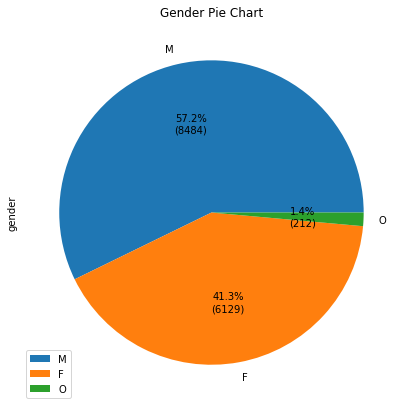

In [0]:
# Display Pie Chart of gender with % and value in the graph.
def autopct_label(pct, allvalues):
    """Recreate the value by multiplying the percentage by the total.
    
    Idea from https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_and_donut_labels.html
    
    Args:
        pct (float) = percent for current piece of the pie.
        allvalues (Pandas Series): all values in the series.
    
    Returns:
        formatted string containing the % and the actual value.
    """
    absolute = int(np.round(pct/100. * np.sum(allvalues)))
    return f"{pct:.1f}%\n({absolute:d})"

profile.gender.value_counts().plot.pie(figsize=(7, 7), 
                                       title="Gender Pie Chart", 
                                       autopct=lambda pct: autopct_label(pct, profile.gender.value_counts()), 
                                       legend=True)

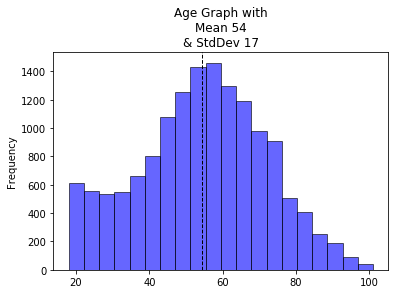

In [0]:
# Plot the ages (excluding the default age of 118) and also plot the mean line.
age_mean = profile[profile.age != 118].age.mean()
age_stddev = profile[profile.age != 118].age.std()
age_plot = profile[profile.age != 118].age.plot(kind='hist', 
                                                bins=20, 
                                                color='b', 
                                                edgecolor='k', 
                                                alpha=0.60,
                                                title=f"Age Graph with\nMean {int(age_mean)}\n& StdDev {int(age_stddev)}")
age_plot.axvline(age_mean, color='k', linestyle='dashed', linewidth=1)

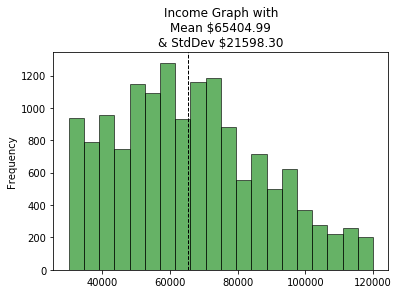

In [0]:
# Plot the incomes (excluding the NaN values) and also plot the mean line.
income_mean = profile.income.mean()
income_stddev = profile.income.std()
income_plot = profile.income.plot(kind='hist', 
                                  bins=20, 
                                  color='g', 
                                  edgecolor='k', 
                                  alpha=0.60, 
                                  title=f"Income Graph with\nMean ${income_mean:.2f}\n& StdDev ${income_stddev:.2f}")
income_plot.axvline(profile.income.mean(), color='k', linestyle='dashed', linewidth=1)

## Transcript.json Data Exploration

In [0]:
# Get a random sample of the data, sorted in original order.
transcript.sample(10).sort_values(by=['time'])

person            event  \
44528   855a636c057e4a32aa50b7d39f24d769      transaction   
55541   2cfd7c204f744227b147546e36c961b0   offer received   
66092   cef9b883c0c947e88659c9eb361b3250      transaction   
91878   3798869304074ff1b1bb1cbf1b352676      transaction   
132694  ac3e5e1cf92a4cbe84636087fa45204a  offer completed   
153233  a54258212fec4086bacd899d252b1088   offer received   
217242  99ffa82129904cd6adabcdfe02072904     offer viewed   
257598  b781e826e90f4161b96794a4c6d6e926   offer received   
284803  1e31703717f6436d837dafa37fd1a4b9      transaction   
293269  893a121f16cb48e89711a566f291bc57      transaction   

                                                    value  time  
44528                                   {'amount': 33.81}   114  
55541    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   168  
66092                                   {'amount': 36.95}   168  
91878                                    {'amount': 3.38}   234  
132694  {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...   348  
153233   {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}   408  
217242   {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}   504  
257598   {'offer id': '3f207df678b143eea3cee63160fa8bed'}   576  
284803                                  {'amount': 15.26}   630  
293269                                   {'amount': 0.52}   660

In [0]:
# Check the datatypes for the columns
# There are 306,534 rows.
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [0]:
# See how many of each event occurred in the transcript.
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

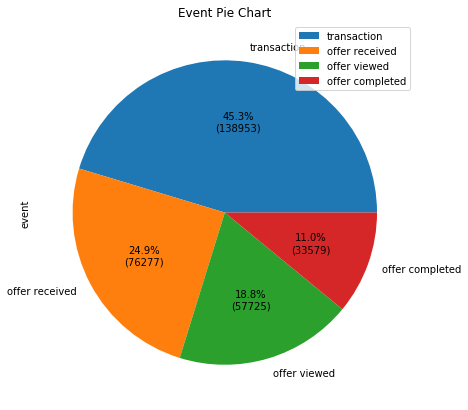

In [0]:
# Graph the event counts.
transcript.event.value_counts().plot.pie(figsize=(7, 7), 
                                       title="Event Pie Chart", 
                                       autopct=lambda pct: autopct_label(pct, transcript.event.value_counts()), 
                                       legend=True)

In [0]:
# To get a better understanding of the data,
# I will find a completed offer, check the corresponding person, and view 
# an offer they received, viewed, and completed.

# View some of the completed offers.
transcript[transcript.event == 'offer completed'].head()

person            event  \
12658  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  offer completed   
12672  fe97aa22dd3e48c8b143116a8403dd52  offer completed   
12679  629fc02d56414d91bca360decdfa9288  offer completed   
12692  676506bad68e4161b9bbaffeb039626b  offer completed   
12697  8f7dd3b2afe14c078eb4f6e6fe4ba97d  offer completed   

                                                   value  time  
12658  {'offer_id': '2906b810c7d4411798c6938adc9daaa5...     0  
12672  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...     0  
12679  {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...     0  
12692  {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...     0  
12697  {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...     0

In [0]:
# Look at a specific person.
transcript[transcript.person == '9fa9ae8f57894cc9a3b8a9bbe0fc1b2f'].head()

person            event  \
36     9fa9ae8f57894cc9a3b8a9bbe0fc1b2f   offer received   
12656  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f     offer viewed   
12657  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f      transaction   
12658  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  offer completed   
27850  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f      transaction   

                                                   value  time  
36      {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
12656   {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
12657                                  {'amount': 34.56}     0  
12658  {'offer_id': '2906b810c7d4411798c6938adc9daaa5...     0  
27850                                  {'amount': 21.55}    42

In [0]:
# The first offer they completed by spending $34.56.
# They received, viewed, and completed the offer on the same day.

# Let's look at the offer itself.
# The discount offer was to spend $10 and receive a reward of $2.
portfolio[portfolio.id == '2906b810c7d4411798c6938adc9daaa5']

reward              channels  difficulty  duration offer_type  \
9       2  [web, email, mobile]          10         7   discount   

                                 id  
9  2906b810c7d4411798c6938adc9daaa5

# Feature Engineering & Data Cleaning

## Portfolio.json Feature Engineering

#### Changes made:
- One-Hot Encode the channel list.
- One-Hot Encode offer_types.
- Drop 'channels' and 'offer_type' columns.
- Move 'id' column to the first column, for display purposes.
- Rename 'id' to 'id_offer'

In [0]:
portfolio.head()

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [0]:
def channel_labels(row, chan):
    """Convert channel list into separate columns,
        with 1 indicating in the list, and 0 otherwise.
    
    Args:
        row (Pandas dataframe row) = current row.
        chan (str) = channel name.
    """
    if chan in row['channels']:
        return 1
    else:
        return 0

In [0]:
def move_id_to_first_col(p, inplace=True):
    """Move the 'id' column to the first column, for display purposes.
    Idea from https://stackoverflow.com/questions/25122099/move-column-by-name-to-front-of-table-in-pandas
    
    Args:
        p (Pandas dataframe) = dataframe to manipulate.
        inplace (bool) = if True, then don't make copy first. False, make copy.
    
    Returns:
        manipulated Pandas dataframe.
    """
    if inplace:
        p_copy = p
    else:
        p_copy = p.copy()
    
    # Get list of the column names.
    cols = list(p_copy.columns)

    # Move id to start of the list
    cols.insert(0, cols.pop(cols.index('id')))

    # Reorder the columns
    p_copy = p_copy.loc[:, cols]
    
    # Return p_copy
    return p_copy

In [0]:
def clean_portfolio():
    """Clean and perform Feature Engineering on the Portfolio dataframe.
    
    Returns:
        manipulated Pandas dataframe.
    """
    # Create a copy.
    p_copy = portfolio.copy()
    
    # One-Hot Encode the channel_list
    for chan in ["email", "mobile", "social", "web"]:
        p_copy[chan] = p_copy.apply(lambda row: channel_labels(row, chan), axis=1)
    
    # Drop channels column
    p_copy.drop(columns=['channels'], inplace=True, axis=1)
    
    # One-Hot Encode each offer_type
    for offer_type in set(p_copy.offer_type.values):
        p_copy[f"offer_{offer_type}"] = p_copy.apply(lambda row: 1 if row["offer_type"] == offer_type else 0, axis=1)
    
    # Drop offer_type column
    p_copy.drop(columns=['offer_type'], inplace=True, axis=1)
    
    # Move "id" to be the first column, for display purposes.
    p_copy = move_id_to_first_col(p_copy)
    
    # Rename "id" column to "id_offer".
    p_copy.rename(columns={'id': 'id_offer'}, inplace=True)
    
    # Return p_copy
    return p_copy

In [0]:
# Shape before cleaning
print(f"Before cleaning, portfolio shape is {portfolio.shape}")

# Clean portfolio.
portfolio = clean_portfolio()

# Shape after cleaning
print(f"After cleaning, portfolio shape is {portfolio.shape}")

Before cleaning, portfolio shape is (10, 6)
After cleaning, portfolio shape is (10, 11)


In [0]:
# Confirm changes.
portfolio

id_offer  reward  difficulty  duration  email  \
0  ae264e3637204a6fb9bb56bc8210ddfd      10          10         7      1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0      10          10         5      1   
2  3f207df678b143eea3cee63160fa8bed       0           0         4      1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9       5           5         7      1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       5          20        10      1   
5  2298d6c36e964ae4a3e7e9706d1fb8c2       3           7         7      1   
6  fafdcd668e3743c1bb461111dcafc2a4       2          10        10      1   
7  5a8bc65990b245e5a138643cd4eb9837       0           0         3      1   
8  f19421c1d4aa40978ebb69ca19b0e20d       5           5         5      1   
9  2906b810c7d4411798c6938adc9daaa5       2          10         7      1   

   mobile  social  web  offer_informational  offer_bogo  offer_discount  
0       1       1    0                    0           1               0  
1       1       1    1                    0           1               0  
2       1       0    1                    1           0               0  
3       1       0    1                    0           1               0  
4       0       0    1                    0           0               1  
5       1       1    1                    0           0               1  
6       1       1    1                    0           0               1  
7       1       1    0                    1           0               0  
8       1       1    1                    0           1               0  
9       1       0    1                    0           0               1

## Profile.json Feature Engineering

#### Changes made:
- Remove customers with missing data.
- Calculate number of days customer has been a member.
- Store the year they became member.
- Split the age into buckets by decade.
- One-Hot Encode each age range.
- One-Hot Encode gender.
- Drop unused columns.
- Move 'id' column to first column, and change name to 'id_customer'.

In [0]:
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [0]:
def clean_profile():
    """Clean and perform Feature Engineering on the profile dataframe.
    
    Returns:
        manipulated Pandas dataframe.
    """
    # Create a copy.
    p_copy = profile.copy()
    
    # Recall that above I found 2175 people had default values. Drop those values.
    p_copy.dropna(inplace=True)
    
    # Calculate number of days customer has been member and store in "membership_total_days".
    p_copy["membership_total_days"] = p_copy.became_member_on.apply(lambda dt: (datetime.today() - datetime.strptime(str(dt), "%Y%m%d")).days)
    
    # Store the year they became member on.
    p_copy["membership_year"] = p_copy.became_member_on.apply(lambda dt: int(str(dt)[:4]))
    
    # Split (cut) age into buckets by decade. (10-19, 20-29, 30-39, etc.)
    # Remove the last digit, then multiply by 10 to get the minimum.
    min_age_bucket = int(profile.age.min()/10)*10
    # Remove the last digit, then multiply by 11 to get the maximum.
    # 11 because we want to include the full decade.
    max_age_bucket = int(profile.age.max()/10)*11
    # Split between the min and max bucket ages in groups of 10
    p_copy["age_range"] = pd.cut(p_copy["age"], range(min_age_bucket, max_age_bucket, 10), right=False)
    
    # One-Hot encode each age_range.
    for age_range in sorted(set(p_copy.age_range.values)):
        p_copy[f"age_{age_range}"] = p_copy.apply(lambda row: 1 if row["age_range"] == age_range else 0, axis=1)
    
    # One-Hot encode gender.
    for gender in set(p_copy.gender.values):
        p_copy[f"gender_{gender}"] = p_copy.apply(lambda row: 1 if row["gender"] == gender else 0, axis=1)
    
    # Drop the age, age_range, became_member_on, and gender columns.
    p_copy.drop(columns=['age', 'age_range', 'became_member_on', 'gender'], inplace=True, axis=1)
    
    # Move "id" to be the first column, for display purposes.
    p_copy = move_id_to_first_col(p_copy)
    
    p_copy.rename(columns={'id': 'id_customer'}, inplace=True)
    
    # Return p_copy
    return p_copy

In [0]:
# Shape before cleaning
print(f"Before cleaning, profile has shape {profile.shape}")

profile = clean_profile()

# Shape after cleaning
print(f"After cleaning, profile has shape {profile.shape}")

Before cleaning, profile has shape (17000, 5)
After cleaning, profile has shape (14825, 17)


In [0]:
# Look at changes
profile.head()

id_customer    income  membership_total_days  \
1   0610b486422d4921ae7d2bf64640c50b  112000.0                    891   
3   78afa995795e4d85b5d9ceeca43f5fef  100000.0                    958   
5   e2127556f4f64592b11af22de27a7932   70000.0                    606   
8   389bc3fa690240e798340f5a15918d5c   53000.0                    682   
12  2eeac8d8feae4a8cad5a6af0499a211d   51000.0                    772   

    membership_year  age_[10, 20)  age_[20, 30)  age_[30, 40)  age_[40, 50)  \
1              2017             0             0             0             0   
3              2017             0             0             0             0   
5              2018             0             0             0             0   
8              2018             0             0             0             0   
12             2017             0             0             0             0   

    age_[50, 60)  age_[60, 70)  age_[70, 80)  age_[80, 90)  age_[90, 100)  \
1              1             0             0             0              0   
3              0             0             1             0              0   
5              0             1             0             0              0   
8              0             1             0             0              0   
12             1             0             0             0              0   

    age_[100, 110)  gender_F  gender_M  gender_O  
1                0         1         0         0  
3                0         1         0         0  
5                0         0         1         0  
8                0         0         1         0  
12               0         0         1         0

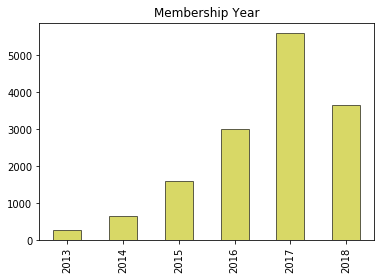

In [0]:
# Plot the number of memberships per year.
# It is increasing every year.  The data only contains up to 20180726,
# so 2018 data is a little over halfway complete.
membership_year_plot = profile.membership_year.value_counts().sort_index().plot(kind='bar',
                                  color='y', 
                                  edgecolor='k', 
                                  alpha=0.60, 
                                  title=f"Membership Year")

## Transcript.json Feature Engineering

#### Changes made:
- Rename 'person' column to 'id_customer'.
- One-Hot encode events
- Get 'offer id' from 'value' column dictionary and place in new column.
- Get 'amount' from 'value' column dictionary and place in new column.
- Drop unused columns

In [0]:
transcript.tail()

person        event  \
306529  b3a1272bc9904337b331bf348c3e8c17  transaction   
306530  68213b08d99a4ae1b0dcb72aebd9aa35  transaction   
306531  a00058cf10334a308c68e7631c529907  transaction   
306532  76ddbd6576844afe811f1a3c0fbb5bec  transaction   
306533  c02b10e8752c4d8e9b73f918558531f7  transaction   

                                 value  time  
306529  {'amount': 1.5899999999999999}   714  
306530                {'amount': 9.53}   714  
306531                {'amount': 3.61}   714  
306532  {'amount': 3.5300000000000002}   714  
306533                {'amount': 4.05}   714

In [0]:
transcript.value.values

array([{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},
       {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},
       {'offer id': '2906b810c7d4411798c6938adc9daaa5'}, ...,
       {'amount': 3.61}, {'amount': 3.5300000000000002}, {'amount': 4.05}],
      dtype=object)

In [0]:
# Get list of unique keys in the 'value' column dictionary
set_of_value_keys = {k for item in transcript.value.values for k in item.keys()}

# Upon investigation, it appears when events are completed the value dict
# contains both 'offer_id' and 'reward'.
# We do not need 'reward' since that is the same 'reward' from the 'portfolio'.
print(f"Found the following keys in the 'values' column:\n{set_of_value_keys}")

Found the following keys in the 'values' column:
{'offer id', 'offer_id', 'reward', 'amount'}


In [0]:
def getOfferFromTranscript(d):
    """Given dictionary, get the offer from it (if present)."""
    if "offer id" in d:
        return d["offer id"]
    elif "offer_id" in d:
        return d["offer_id"]
    else:
        return np.nan

def getAmountFromTranscript(d):
    """Given dictionary, get the amount from it (if present)."""
    if "amount" in d:
        return d["amount"]
    else:
        return np.nan

In [0]:
def clean_transcript():
    """Clean and perform Feature Engineering on the transcript dataframe.
    
    Returns:
        manipulated Pandas dataframe.
    """
    # Create a copy.
    p_copy = transcript.copy()
    
    # Rename "person" to be "id_customer" to match Profile dataframe.
    p_copy.rename(columns={'person': 'id_customer'}, inplace=True)
    
    # Since we dropped the N/A rows from profile, need to also drop all transactions
    # pertaining to that customer.
    p_copy = p_copy[p_copy.id_customer.isin(profile.id_customer.values)]
    
    # One-Hot encode event.
    for event in set(p_copy.event.values):
        p_copy[f"event_{event}"] = p_copy.apply(lambda row: 1 if row["event"] == event else 0, axis=1)
    
    # Get 'offer id' from value column dictionary and place in new column.
    p_copy["id_offer"] = p_copy.value.apply(lambda v: getOfferFromTranscript(v))
    
    # Get 'amount' from value column dictionary and place in new column.
    p_copy["trans_amt"] = p_copy.value.apply(lambda v: getAmountFromTranscript(v))
    
    # Drop unused columns
    p_copy.drop(columns=['event', 'value'], inplace=True, axis=1)
    
    # Convert all spaces in column names to _
    p_copy.columns = [s.replace(" ", "_") for s in p_copy.columns]
        
    # Return p_copy
    return p_copy

In [0]:
# Shape before cleaning
print(f"Before cleaning, transcript has shape {transcript.shape}")

transcript = clean_transcript()

# Shape after cleaning
print(f"After cleaning, transcript has shape {transcript.shape}")

Before cleaning, transcript has shape (306534, 4)
After cleaning, transcript has shape (272762, 8)


In [0]:
transcript.head()

id_customer  time  event_offer_viewed  \
0  78afa995795e4d85b5d9ceeca43f5fef     0                   0   
2  e2127556f4f64592b11af22de27a7932     0                   0   
5  389bc3fa690240e798340f5a15918d5c     0                   0   
7  2eeac8d8feae4a8cad5a6af0499a211d     0                   0   
8  aa4862eba776480b8bb9c68455b8c2e1     0                   0   

   event_transaction  event_offer_received  event_offer_completed  \
0                  0                     1                      0   
2                  0                     1                      0   
5                  0                     1                      0   
7                  0                     1                      0   
8                  0                     1                      0   

                           id_offer  trans_amt  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9        NaN  
2  2906b810c7d4411798c6938adc9daaa5        NaN  
5  f19421c1d4aa40978ebb69ca19b0e20d        NaN  
7  3f207df678b143eea3cee63160fa8bed        NaN  
8  0b1e1539f2cc45b7b9fa7c272da2e1d7        NaN

In [0]:
transcript.tail()

id_customer  time  event_offer_viewed  \
306527  24f56b5e1849462093931b164eb803b5   714                   0   
306529  b3a1272bc9904337b331bf348c3e8c17   714                   0   
306530  68213b08d99a4ae1b0dcb72aebd9aa35   714                   0   
306531  a00058cf10334a308c68e7631c529907   714                   0   
306532  76ddbd6576844afe811f1a3c0fbb5bec   714                   0   

        event_transaction  event_offer_received  event_offer_completed  \
306527                  0                     0                      1   
306529                  1                     0                      0   
306530                  1                     0                      0   
306531                  1                     0                      0   
306532                  1                     0                      0   

                                id_offer  trans_amt  
306527  fafdcd668e3743c1bb461111dcafc2a4        NaN  
306529                               NaN       1.59  
306530                               NaN       9.53  
306531                               NaN       3.61  
306532                               NaN       3.53

## Perform checks regarding if a customer received the same offer multiple times

In [0]:
# Check if any customer received the same offer multiple times.
cust_offer_ids = transcript.apply(lambda row: f"{row['id_customer']}_{row['id_offer']}" if (row['event_offer_received']) else np.nan, axis=1)

In [0]:
# Check the counts and see that some customers did receive the same offer multiple times.
cust_offer_ids.value_counts()

6d2db3aad94648259e539920fc2cf2a6_f19421c1d4aa40978ebb69ca19b0e20d    5
43a50d7e5c8547a9aa1ec31291b9fc30_0b1e1539f2cc45b7b9fa7c272da2e1d7    5
23d67a23296a485781e69c109a10a1cf_5a8bc65990b245e5a138643cd4eb9837    5
eece6a9a7bdd4ea1b0f812f34fc619d6_5a8bc65990b245e5a138643cd4eb9837    5
ebf0ac82b55d436bb6a53ccf910cd759_2298d6c36e964ae4a3e7e9706d1fb8c2    4
                                                                    ..
0d6cc5eb3fb84a05aaa042abfd286945_ae264e3637204a6fb9bb56bc8210ddfd    1
1c52cb8ec73a4b76bf01bfcf0823aee0_ae264e3637204a6fb9bb56bc8210ddfd    1
56a30c95a6cf4950b5dcade44b0b5dac_fafdcd668e3743c1bb461111dcafc2a4    1
d4d761c0366d46fdb3bb2878f7023ed6_4d5c57ea9a6940dd891ad53e9dbe8da0    1
6da3d0b813734fa3b1697119c6d75c8b_f19421c1d4aa40978ebb69ca19b0e20d    1
Length: 55222, dtype: int64

In [0]:
# Look at the first entry and see the same was received 5 times by the same customer.
transcript[(transcript.event_offer_received) & (transcript.id_customer == "43a50d7e5c8547a9aa1ec31291b9fc30") & (transcript.id_offer == "0b1e1539f2cc45b7b9fa7c272da2e1d7")]

id_customer  time  event_offer_viewed  \
5619    43a50d7e5c8547a9aa1ec31291b9fc30     0                   0   
58837   43a50d7e5c8547a9aa1ec31291b9fc30   168                   0   
118032  43a50d7e5c8547a9aa1ec31291b9fc30   336                   0   
155682  43a50d7e5c8547a9aa1ec31291b9fc30   408                   0   
250751  43a50d7e5c8547a9aa1ec31291b9fc30   576                   0   

        event_transaction  event_offer_received  event_offer_completed  \
5619                    0                     1                      0   
58837                   0                     1                      0   
118032                  0                     1                      0   
155682                  0                     1                      0   
250751                  0                     1                      0   

                                id_offer  trans_amt  
5619    0b1e1539f2cc45b7b9fa7c272da2e1d7        NaN  
58837   0b1e1539f2cc45b7b9fa7c272da2e1d7        NaN  
118032  0b1e1539f2cc45b7b9fa7c272da2e1d7        NaN  
155682  0b1e1539f2cc45b7b9fa7c272da2e1d7        NaN  
250751  0b1e1539f2cc45b7b9fa7c272da2e1d7        NaN

In [0]:
# Look at specific offer.
portfolio[portfolio.id_offer == "0b1e1539f2cc45b7b9fa7c272da2e1d7"]

id_offer  reward  difficulty  duration  email  \
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       5          20        10      1   

   mobile  social  web  offer_informational  offer_bogo  offer_discount  
4       0       0    1                    0           0               1

In [0]:
# Check if received same offer at same time stamp multiple times.
ts_cust_offer_ids = transcript.apply(lambda row: f"{row['time']}_{row['id_customer']}_{row['id_offer']}" if (row['event_offer_received']) else np.nan, axis=1)

In [0]:
# Only one of the same offer at a time
ts_cust_offer_ids.value_counts()

168_00b3400e4ff64ee68ce9ada1d0c222f0_ae264e3637204a6fb9bb56bc8210ddfd    1
336_058b4e5020734ba7b48b0b43119bab0f_f19421c1d4aa40978ebb69ca19b0e20d    1
336_2acc7c8939034af1b712b3568af31a44_fafdcd668e3743c1bb461111dcafc2a4    1
336_a50f214a50954eeca6b547e275569e08_2298d6c36e964ae4a3e7e9706d1fb8c2    1
0_722c090fe88445eeb9f32ad8bcdbc05a_4d5c57ea9a6940dd891ad53e9dbe8da0      1
                                                                        ..
0_a13d12b423c0443cbaa3815ce04ed056_0b1e1539f2cc45b7b9fa7c272da2e1d7      1
504_ec539cd856754923995755f0dd1af470_f19421c1d4aa40978ebb69ca19b0e20d    1
0_e99d297afce1463daade7868c26e298b_0b1e1539f2cc45b7b9fa7c272da2e1d7      1
0_3622ada8c6394b32a8d7ba31c737e926_ae264e3637204a6fb9bb56bc8210ddfd      1
576_d0c9c4785bf34d839b31485a37bf25ca_9b98b8c7a33c4b65b9aebfe6a799e6d9    1
Length: 66501, dtype: int64

In [0]:
# Check if customer received multiple offers at same timestamp.
ts_cust_ids = transcript.apply(lambda row: f"{row['time']}_{row['id_customer']}" if (row['event_offer_received']) else np.nan, axis=1)

In [0]:
# Customers only received single offer at a single timestamp.
ts_cust_ids.value_counts()

504_6b64bd90a25b4c1399eb9f6e29a4d6f4    1
408_131d42c477cf4ea9a4823922d1f3f831    1
408_608c020e793c41aabc2570557ab38551    1
504_0a3c4a0c066d49f1ad4eb52987a0fb05    1
408_42ef6b1a574d43e69750a3c7fd378ef4    1
                                       ..
168_b694ab6e982a4734be5bb6e0e7ec6e25    1
336_2524958e4c684e508ec5c42e5600ec20    1
168_907a887894d14bcc9dc55d24a2e3c464    1
168_39b5141021e94f5ab6ac11139e61b582    1
336_a8986824f77142d3bf502e5c62e1e0b3    1
Length: 66501, dtype: int64

In [0]:
# Iterate over all rows in 'combined' and store info in cust_offer_dict.
# After collected, create new columns based on data stored in there.

def offer_dict_factory():
    """Factory used for creating default dictionary with the following keys:
    
    # Keep counters of events for this offer.
    -'num_times_received' (int) = Keep track of number of times customer has received this offer.
    -'num_times_viewed' (int) = Keep track of number of times customer has viewed this offer.
    -'num_times_completed' (int) = Keep track of number of times customer has completed this offer.
    
    # Amount spent.
    -'total_amt_spent_toward_offer' (float) = total amount spent from when offer received until it expires.
    
    """
    return {
        'num_times_received': 0,
        'num_times_viewed': 0,
        'num_times_completed': 0,
        'total_amt_spent_toward_offer': 0.0
    }

def cust_dict_factory():
    """Factory used for creating default dictionary with the following keys:
    
    -'active_offers' (dict) = key of active id_offer's and value of expiration timestamp.
            If we were to receive another of the same offer before the previous one expired,
            we would just update the value for the new offer.
    -'offers' (dict) = key is 'id_offer' and dict from offer_dict_factory.
    -'total_amt_spent_not_in_offer' (float) = Total amount customer spent not associated with any offer.
    
    """
    return {
        'active_offers': {},  # dict with key of active id_offer's and value of expiration timestamp.
        'offers': defaultdict(lambda: offer_dict_factory()),  # dict holding details of all offers.
        'total_amt_spent_not_in_offer': 0.0
    }



# Helper functions to hold difficulty and duration for each offer.
offer_difficulty = {l[0]: l[1] for l in portfolio.loc[:, ['id_offer', 'difficulty']].values}
offer_duration = {l[0]: l[1] for l in portfolio.loc[:, ['id_offer', 'duration']].values}

# Initialize customer offer dictionary.
cust_offer_dict = defaultdict(lambda: cust_dict_factory())

# Iterate over the rows.
# Per this article, itertuples is significantly faster than iterrows:
# https://medium.com/swlh/why-pandas-itertuples-is-faster-than-iterrows-and-how-to-make-it-even-faster-bc50c0edd30d
for row in transcript.itertuples(index=False):
    # Store values from row for easy access.
    timestamp = row.time
    cust_id = row.id_customer
    offer_id = row.id_offer
    offer_rcvd = row.event_offer_received
    offer_view = row.event_offer_viewed
    offer_complete = row.event_offer_completed
    transaction = row.event_transaction
    amt = row.trans_amt
    
    # Check if any offers for customer have expired and remove from 'active_offers'.
    expired_offers = [k for k,v in cust_offer_dict[cust_id]['active_offers'].items() if timestamp > v]
    if expired_offers:
        # Offers have expired.
        # Remove them from 'active_offers'.
        for exp in expired_offers:
            del cust_offer_dict[cust_id]['active_offers'][exp]
    
    
    # Go through each event type.
    if offer_rcvd:
        # Received the offer.
        # Add offer to 'active_offers' with expiration timestamp.
        # Check if multiple offers are active at the same time and display WARNING message.
        # Update 'num_times_received' in 'offers' dict. Since defaultdict, it will create it if not already present.

        # Add offer to 'active_offers' with value as the expiration time.
        # - timestamp is in hours.
        # - duration is in days.
        # - Need to convert expiration to be in hours.
        expiration_time = timestamp + (offer_duration[offer_id] * 24)
        cust_offer_dict[cust_id]['active_offers'][offer_id] = expiration_time
        
        # Verify we do not have multiple offers active at the same time.
        if len(cust_offer_dict[cust_id]['active_offers']) > 1:
            print(f"WARNING: Multiple offers active for customer {cust_id}: {cust_offer_dict[cust_id]['active_offers']}")
        
        # Update number of times received.
        cust_offer_dict[cust_id]['offers'][offer_id]['num_times_received'] += 1
        
    elif offer_view:
        # Viewed the offer.
        # Update 'num_times_viewed'.
        cust_offer_dict[cust_id]['offers'][offer_id]['num_times_viewed'] += 1
    
    elif offer_complete:
        # Completed offer.
        # Update 'num_times_completed'
        cust_offer_dict[cust_id]['offers'][offer_id]['num_times_completed'] += 1
    
    elif transaction:
        # Check if any active offers.
        if cust_offer_dict[cust_id]['active_offers']:
            # Update 'total_amt_spent_toward_offer'
            for offer in cust_offer_dict[cust_id]['active_offers'].keys():
                cust_offer_dict[cust_id]['offers'][offer]['total_amt_spent_toward_offer'] += amt
        else:
            # No active offer.
            # Update 'total_amt_spent_not_in_offer'.
            cust_offer_dict[cust_id]['total_amt_spent_not_in_offer'] += amt
    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
# Print the dictionary we built.
cust_offer_dict

defaultdict(<function __main__.<lambda>()>,
            {'78afa995795e4d85b5d9ceeca43f5fef': {'active_offers': {'f19421c1d4aa40978ebb69ca19b0e20d': 624},
              'offers': defaultdict(<function __main__.cust_dict_factory.<locals>.<lambda>()>,
                          {'9b98b8c7a33c4b65b9aebfe6a799e6d9': {'num_times_received': 1,
                            'num_times_viewed': 1,
                            'num_times_completed': 1,
                            'total_amt_spent_toward_offer': 37.67},
                           '5a8bc65990b245e5a138643cd4eb9837': {'num_times_received': 1,
                            'num_times_viewed': 1,
                            'num_times_completed': 0,
                            'total_amt_spent_toward_offer': 49.39},
                           'ae264e3637204a6fb9bb56bc8210ddfd': {'num_times_received': 1,
                            'num_times_viewed': 1,
                            'num_times_completed': 1,
                            'tota

In [0]:
# Go through 'profile' and 'transcript' and add new columns for each key of cust_offer_dict (and keys of 'offers')
profile['amount_spent_not_in_offer'] = profile.apply(lambda row: cust_offer_dict[row['id_customer']]['total_amt_spent_not_in_offer'], axis=1)

transcript['num_times_received'] = transcript.apply(lambda row: 
                                                    cust_offer_dict[row['id_customer']]['offers'][row['id_offer']]['num_times_received'], axis=1)
transcript['num_times_viewed'] = transcript.apply(lambda row: 
                                                    cust_offer_dict[row['id_customer']]['offers'][row['id_offer']]['num_times_viewed'], axis=1)
transcript['num_times_completed'] = transcript.apply(lambda row: 
                                                    cust_offer_dict[row['id_customer']]['offers'][row['id_offer']]['num_times_completed'], axis=1)
transcript['total_amt_spent_towards_offer'] = transcript.apply(lambda row: 
                                                    np.round(cust_offer_dict[row['id_customer']]['offers'][row['id_offer']]['total_amt_spent_toward_offer'], decimals=2), axis=1)
transcript['avg_amt_spent_towards_offer'] = transcript.apply(lambda row: 
                                                    np.round(cust_offer_dict[row['id_customer']]['offers'][row['id_offer']]['total_amt_spent_toward_offer'] / cust_offer_dict[row['id_customer']]['offers'][row['id_offer']]['num_times_received'], decimals=2)
                                                             if cust_offer_dict[row['id_customer']]['offers'][row['id_offer']]['num_times_received'] else 0, axis=1)

In [0]:
profile.head()

id_customer    income  membership_total_days  \
1   0610b486422d4921ae7d2bf64640c50b  112000.0                    891   
3   78afa995795e4d85b5d9ceeca43f5fef  100000.0                    958   
5   e2127556f4f64592b11af22de27a7932   70000.0                    606   
8   389bc3fa690240e798340f5a15918d5c   53000.0                    682   
12  2eeac8d8feae4a8cad5a6af0499a211d   51000.0                    772   

    membership_year  age_[10, 20)  age_[20, 30)  age_[30, 40)  age_[40, 50)  \
1              2017             0             0             0             0   
3              2017             0             0             0             0   
5              2018             0             0             0             0   
8              2018             0             0             0             0   
12             2017             0             0             0             0   

    age_[50, 60)  age_[60, 70)  age_[70, 80)  age_[80, 90)  age_[90, 100)  \
1              1             0             0             0              0   
3              0             0             1             0              0   
5              0             1             0             0              0   
8              0             1             0             0              0   
12             1             0             0             0              0   

    age_[100, 110)  gender_F  gender_M  gender_O  amount_spent_not_in_offer  
1                0         1         0         0                      53.79  
3                0         1         0         0                      23.93  
5                0         0         1         0                      39.31  
8                0         0         1         0                       0.00  
12               0         0         1         0                       0.00

In [0]:
transcript.head()

id_customer  time  event_offer_viewed  \
0  78afa995795e4d85b5d9ceeca43f5fef     0                   0   
2  e2127556f4f64592b11af22de27a7932     0                   0   
5  389bc3fa690240e798340f5a15918d5c     0                   0   
7  2eeac8d8feae4a8cad5a6af0499a211d     0                   0   
8  aa4862eba776480b8bb9c68455b8c2e1     0                   0   

   event_transaction  event_offer_received  event_offer_completed  \
0                  0                     1                      0   
2                  0                     1                      0   
5                  0                     1                      0   
7                  0                     1                      0   
8                  0                     1                      0   

                           id_offer  trans_amt  num_times_received  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9        NaN                   1   
2  2906b810c7d4411798c6938adc9daaa5        NaN                   1   
5  f19421c1d4aa40978ebb69ca19b0e20d        NaN                   2   
7  3f207df678b143eea3cee63160fa8bed        NaN                   1   
8  0b1e1539f2cc45b7b9fa7c272da2e1d7        NaN                   1   

   num_times_viewed  num_times_completed  total_amt_spent_towards_offer  \
0                 1                    1                          37.67   
2                 1                    0                           0.00   
5                 2                    2                          20.80   
7                 0                    0                           0.00   
8                 1                    0                          12.33   

   avg_amt_spent_towards_offer  
0                        37.67  
2                         0.00  
5                        10.40  
7                         0.00  
8                        12.33

In [0]:
# Shape before secondary cleaning
print(f"Before secondary cleaning, transcript has shape {transcript.shape}")

# I can now drop multiple columns from transcript.
transcript.drop(columns=['time', 'event_offer_completed', 'event_transaction', 
                        'event_offer_received', 'event_offer_viewed', 'trans_amt'], inplace=True, axis=1)

transcript.drop_duplicates(inplace=True)

# Shape after secondary cleaning
print(f"After secondary cleaning, transcript has shape {transcript.shape}")

Before secondary cleaning, transcript has shape (272762, 13)
After secondary cleaning, transcript has shape (69714, 7)


In [0]:
# Check how many customers did not receive any offers.
print(f"There are {len([c for c in cust_offer_dict.keys() if not len(cust_offer_dict[c]['offers'])])} customers that did NOT receive an offer.")
# Therefore, every customer received at least one offer.

# Check the counts of offers sent to customers.
print(f"The counts of offers sent to customers were: {set([len(cust_offer_dict[c]['offers']) for c in cust_offer_dict.keys()])}")
# Therefore, between 1-7 offers were sent to each customer.

There are 0 customers that did NOT receive an offer.
The counts of offers sent to customers were: {1, 2, 3, 4, 5, 6, 7}


## Combine Data.

#### Changes made:
- Join the data together.
- Iterate over transcript data for each customer.
   - When an offer is received, get the total amount purchased within the 'duration' for that customer and offer.
- For each offer we can look at a specific customer to see:
   - How much they spent towards that offer?
   - Did they view the offer?
   - Did they complete the offer?

In [0]:
# Merge them together.
combined = pd.merge(transcript, portfolio, how='left', on="id_offer")
combined = pd.merge(combined, profile, how='left', on="id_customer")

In [0]:
combined.head()

id_customer                          id_offer  \
0  78afa995795e4d85b5d9ceeca43f5fef  9b98b8c7a33c4b65b9aebfe6a799e6d9   
1  e2127556f4f64592b11af22de27a7932  2906b810c7d4411798c6938adc9daaa5   
2  389bc3fa690240e798340f5a15918d5c  f19421c1d4aa40978ebb69ca19b0e20d   
3  2eeac8d8feae4a8cad5a6af0499a211d  3f207df678b143eea3cee63160fa8bed   
4  aa4862eba776480b8bb9c68455b8c2e1  0b1e1539f2cc45b7b9fa7c272da2e1d7   

   num_times_received  num_times_viewed  num_times_completed  \
0                   1                 1                    1   
1                   1                 1                    0   
2                   2                 2                    2   
3                   1                 0                    0   
4                   1                 1                    0   

   total_amt_spent_towards_offer  avg_amt_spent_towards_offer  reward  \
0                          37.67                        37.67     5.0   
1                           0.00                         0.00     2.0   
2                          20.80                        10.40     5.0   
3                           0.00                         0.00     0.0   
4                          12.33                        12.33     5.0   

   difficulty  duration  ...  age_[50, 60)  age_[60, 70)  age_[70, 80)  \
0         5.0       7.0  ...             0             0             1   
1        10.0       7.0  ...             0             1             0   
2         5.0       5.0  ...             0             1             0   
3         0.0       4.0  ...             1             0             0   
4        20.0      10.0  ...             0             1             0   

   age_[80, 90)  age_[90, 100)  age_[100, 110)  gender_F  gender_M  gender_O  \
0             0              0               0         1         0         0   
1             0              0               0         0         1         0   
2             0              0               0         0         1         0   
3             0              0               0         0         1         0   
4             0              0               0         1         0         0   

   amount_spent_not_in_offer  
0                      23.93  
1                      39.31  
2                       0.00  
3                       0.00  
4                       0.00  

[5 rows x 34 columns]

In [0]:
combined.columns

Index(['id_customer', 'id_offer', 'num_times_received', 'num_times_viewed',
       'num_times_completed', 'total_amt_spent_towards_offer',
       'avg_amt_spent_towards_offer', 'reward', 'difficulty', 'duration',
       'email', 'mobile', 'social', 'web', 'offer_informational', 'offer_bogo',
       'offer_discount', 'income', 'membership_total_days', 'membership_year',
       'age_[10, 20)', 'age_[20, 30)', 'age_[30, 40)', 'age_[40, 50)',
       'age_[50, 60)', 'age_[60, 70)', 'age_[70, 80)', 'age_[80, 90)',
       'age_[90, 100)', 'age_[100, 110)', 'gender_F', 'gender_M', 'gender_O',
       'amount_spent_not_in_offer'],
      dtype='object')

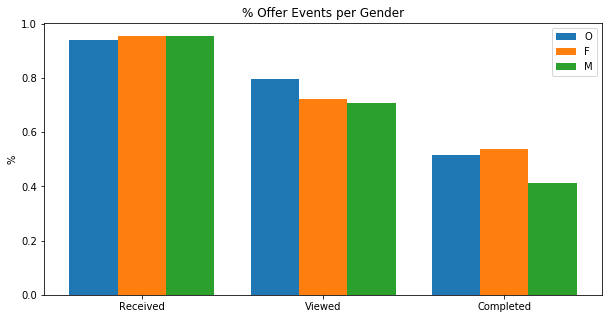

In [0]:
# Ideas from:
# https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781849513265/1/ch01lvl1sec16/plotting-multiple-bar-charts
# https://matplotlib.org/3.1.1/gallery/units/bar_unit_demo.html
def getOffersPerGenderData(gender):
    """Get data for number of offers received/viewed/completed per gender.
    
    Args:
        -gender (str) = M, F, or O.
    
    Returns:
        -list containing percentage based on number of offer event per gender / total number of gender.
    """
    # Initialize list to hold data for graph.
    data = []
    
    for x in ['num_times_received', 'num_times_viewed', 'num_times_completed']:
        data.append(combined.groupby(by=f"gender_{gender}")[x].sum()[1] / combined.groupby(by=f"gender_{gender}")[f"gender_{gender}"].sum()[1])
    
    return data

def graphOffersPerGender():
    """Graph total number of offers received/viewed/completed per gender.
    """
    # List of lists containing data for all genders.
    all_data = [getOffersPerGenderData('O'), getOffersPerGenderData('F'), getOffersPerGenderData('M')]

    f, ax = plt.subplots()
    f.set_figheight(5)
    f.set_figwidth(10)
    gap = .8 / len(all_data)
    for idx, row in enumerate(all_data):
        X = np.arange(len(row))
        ax.bar(X + idx * gap, row, width=gap)
        ax.legend(['O', 'F', 'M'])
        ax.set_title('% Offer Events per Gender')
        ax.set_xticks(X + idx * gap / 2)
        ax.set_xticklabels(('Received', 'Viewed', 'Completed'))
        ax.set_ylabel("%")

graphOffersPerGender()

From this we see that `received` was fairly even for all genders.

Majority of all genders `viewed`.

Roughly half of Other and Female `completed`. Less than half of Males `completed`.

In [0]:
combined.columns

Index(['id_customer', 'id_offer', 'num_times_received', 'num_times_viewed',
       'num_times_completed', 'total_amt_spent_towards_offer',
       'avg_amt_spent_towards_offer', 'reward', 'difficulty', 'duration',
       'email', 'mobile', 'social', 'web', 'offer_informational', 'offer_bogo',
       'offer_discount', 'income', 'membership_total_days', 'membership_year',
       'age_[10, 20)', 'age_[20, 30)', 'age_[30, 40)', 'age_[40, 50)',
       'age_[50, 60)', 'age_[60, 70)', 'age_[70, 80)', 'age_[80, 90)',
       'age_[90, 100)', 'age_[100, 110)', 'gender_F', 'gender_M', 'gender_O',
       'amount_spent_not_in_offer'],
      dtype='object')

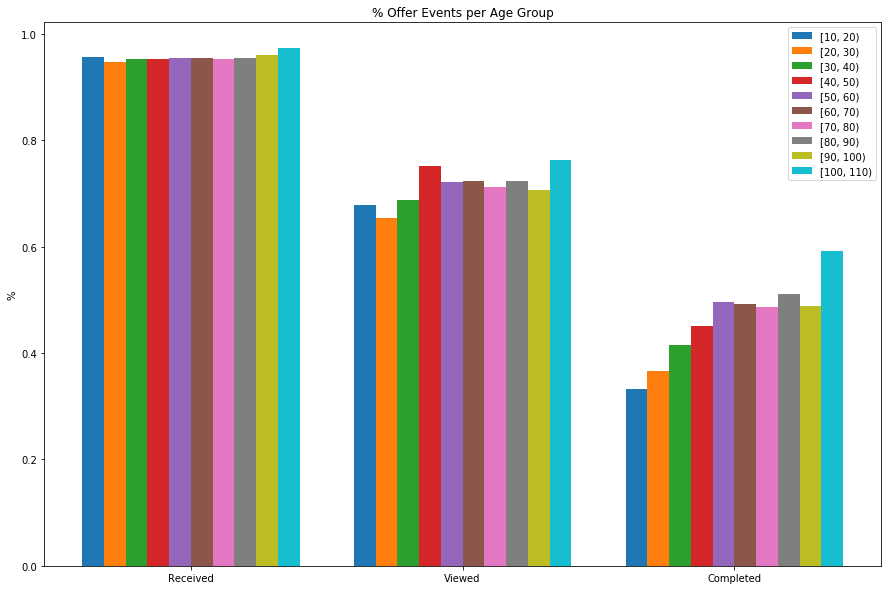

In [0]:
# Graph total number of offers received/viewed/completed per age group.
def getOffersPerAgeData(age):
    """Get data for number of offers received/viewed/completed per age group.
    
    Args:
        -age group (str) = One of the age groups in our data.
    
    Returns:
        -list containing percentage based on number of offer event per age group / total number of age group.
    """
    # Initialize list to hold data for graph.
    data = []
    
    for x in ['num_times_received', 'num_times_viewed', 'num_times_completed']:
        data.append(combined.groupby(by=age)[x].sum()[1] / combined.groupby(by=age)[age].sum()[1])
    
    return data

def graphOffersPerAgeGroup():
    """Graph total number of offers received/viewed/completed per age group.
    """
    # List of lists containing data for all age groups.
    all_data = []

    # Collect labels for legend.
    legend_labels = []
    for col in combined.columns:
        if col.startswith("age_"):
            legend_labels.append(col.split("_")[1])
            all_data.append(getOffersPerAgeData(col))

    f, ax = plt.subplots()
    f.set_figheight(10)
    f.set_figwidth(15)
    gap = .8 / len(all_data)
    for idx, row in enumerate(all_data):
        X = np.arange(len(row))
        ax.bar(X + idx * gap, row, width=gap)
        ax.legend(legend_labels)
        ax.set_title('% Offer Events per Age Group')
        ax.set_xticks(X + idx * gap / 2)
        ax.set_xticklabels(('Received', 'Viewed', 'Completed'))
        ax.set_ylabel("%")

graphOffersPerAgeGroup()

The interesting thing about the above graph is that the younger age groups did not complete as many offers, while the older age groups did. This is roughly linear increase %-wise from age 10 to 59.

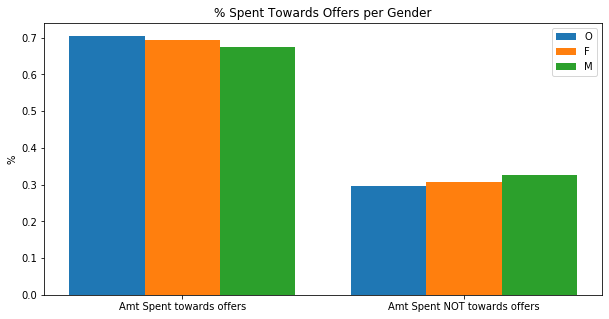

In [0]:
# Total amount spent toward offers vs. Total amount spent not in offers per gender.
def getAmtSpentPerGenderData(gender):
    """Get data for amount spent towards offers vs. amount spent not in offers per gender.
    
    Args:
        -gender (str) = M, F, or O.
    
    Returns:
        -list containing percentage based on (amount spent per gender in offers / total amount spent for gender)
            and (amount spent per gender NOT in offers / total amount spent for gender).
    """
    # Initialize list to hold data for graph.
    data = []
    
    total_spent = combined.groupby(by=f"gender_{gender}")['total_amt_spent_towards_offer'].sum()[1] + combined.groupby(by=f"gender_{gender}")['amount_spent_not_in_offer'].sum()[1]
    
    for x in ['total_amt_spent_towards_offer', 'amount_spent_not_in_offer']:
        x_sum = combined.groupby(by=f"gender_{gender}")[x].sum()[1]
        
        data.append(x_sum / total_spent)
    
    return data

def graphAmtSpentPerGender():
    """Graph total number of offers received/viewed/completed per gender.
    """
    # List of lists containing data for all genders.
    all_data = [getAmtSpentPerGenderData('O'), getAmtSpentPerGenderData('F'), getAmtSpentPerGenderData('M')]

    f, ax = plt.subplots()
    f.set_figheight(5)
    f.set_figwidth(10)
    gap = .8 / len(all_data)
    for idx, row in enumerate(all_data):
        X = np.arange(len(row))
        ax.bar(X + idx * gap, row, width=gap)
        ax.legend(['O', 'F', 'M'])
        ax.set_title('% Spent Towards Offers per Gender')
        ax.set_xticks(X + idx * gap / 2)
        ax.set_xticklabels(('Amt Spent towards offers', 'Amt Spent NOT towards offers'))
        ax.set_ylabel("%")

graphAmtSpentPerGender()

Every gender spends more when there are offers than when there are not.

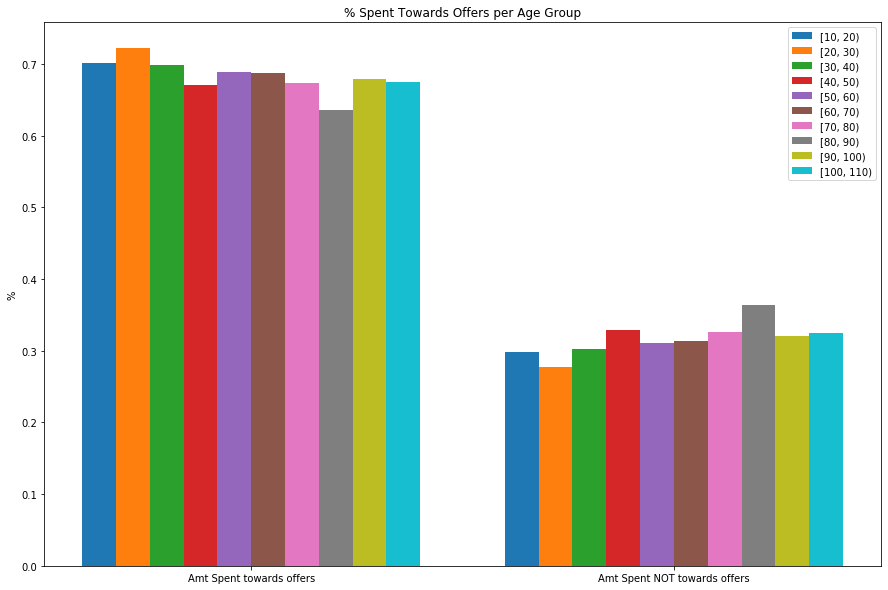

In [0]:
# Total amount spent toward offers vs. Total amount spent not in offers per age group.
def getAmtPerAgeData(age):
    """Get data for amount spent towards offers vs. amount spent not in offers per age group.
    
    Args:
        -age group (str) = One of the age groups in our data.
    
    Returns:
        -list containing percentage based on (amount spent per age group in offers / total amount spent for age group)
            and (amount spent per age group NOT in offers / total amount spent for age group).
    """
    # Initialize list to hold data for graph.
    data = []
    
    total_spent = combined.groupby(by=age)['total_amt_spent_towards_offer'].sum()[1] + combined.groupby(by=age)['amount_spent_not_in_offer'].sum()[1]
    
    for x in ['total_amt_spent_towards_offer', 'amount_spent_not_in_offer']:
        x_sum = combined.groupby(by=age)[x].sum()[1]
        
        data.append(x_sum / total_spent)
    
    return data

def graphAmtPerAgeGroup():
    """Graph total number of offers received/viewed/completed per age group.
    """
    # List of lists containing data for all age groups.
    all_data = []

    # Collect labels for legend.
    legend_labels = []
    for col in combined.columns:
        if col.startswith("age_"):
            legend_labels.append(col.split("_")[1])
            all_data.append(getAmtPerAgeData(col))

    f, ax = plt.subplots()
    f.set_figheight(10)
    f.set_figwidth(15)
    gap = .8 / len(all_data)
    for idx, row in enumerate(all_data):
        X = np.arange(len(row))
        ax.bar(X + idx * gap, row, width=gap)
        ax.legend(legend_labels)
        ax.set_title('% Spent Towards Offers per Age Group')
        ax.set_xticks(X + idx * gap / 2)
        ax.set_xticklabels(('Amt Spent towards offers', 'Amt Spent NOT towards offers'))
        ax.set_ylabel("%")

graphAmtPerAgeGroup()

Every age group spent more towards offers

In [0]:
# Every offer is sent via email, so this column can be removed since it is always 1.
combined[combined.email == 0]

Empty DataFrame
Columns: [id_customer, id_offer, num_times_received, num_times_viewed, num_times_completed, total_amt_spent_towards_offer, avg_amt_spent_towards_offer, reward, difficulty, duration, email, mobile, social, web, offer_informational, offer_bogo, offer_discount, income, membership_total_days, membership_year, age_[10, 20), age_[20, 30), age_[30, 40), age_[40, 50), age_[50, 60), age_[60, 70), age_[70, 80), age_[80, 90), age_[90, 100), age_[100, 110), gender_F, gender_M, gender_O, amount_spent_not_in_offer]
Index: []

[0 rows x 34 columns]

In [0]:
# Informational offers are never "completed". These can be dropped.
# They may or may not lead to sales, but it is hard to determine correlation.
combined[(combined.offer_informational == 1) & (combined.num_times_completed != 0)]

Empty DataFrame
Columns: [id_customer, id_offer, num_times_received, num_times_viewed, num_times_completed, total_amt_spent_towards_offer, avg_amt_spent_towards_offer, reward, difficulty, duration, email, mobile, social, web, offer_informational, offer_bogo, offer_discount, income, membership_total_days, membership_year, age_[10, 20), age_[20, 30), age_[30, 40), age_[40, 50), age_[50, 60), age_[60, 70), age_[70, 80), age_[80, 90), age_[90, 100), age_[100, 110), gender_F, gender_M, gender_O, amount_spent_not_in_offer]
Index: []

[0 rows x 34 columns]

In [0]:
combined.columns

Index(['id_customer', 'id_offer', 'num_times_received', 'num_times_viewed',
       'num_times_completed', 'total_amt_spent_towards_offer',
       'avg_amt_spent_towards_offer', 'reward', 'difficulty', 'duration',
       'email', 'mobile', 'social', 'web', 'offer_informational', 'offer_bogo',
       'offer_discount', 'income', 'membership_total_days', 'membership_year',
       'age_[10, 20)', 'age_[20, 30)', 'age_[30, 40)', 'age_[40, 50)',
       'age_[50, 60)', 'age_[60, 70)', 'age_[70, 80)', 'age_[80, 90)',
       'age_[90, 100)', 'age_[100, 110)', 'gender_F', 'gender_M', 'gender_O',
       'amount_spent_not_in_offer'],
      dtype='object')

## Prepare data for model

1. Modify data.
    - We need a column to indicate if the specific offer was "successful" or not.
    - We can drop all 'offer_informational' rows, since they are never "completed".
    - Remove rows where id_offer is NaN.
    - We do not need the "id_customer" column since we want to generalize to look at the offer as a whole.
    - We do not need 'num_times_received', 'num_times_viewed', 'num_times_completed', 'membership_year'.
    - We can drop 'email' column since it is always 1.
    - We can also drop 'amount_spent_not_in_offer' since that was only used for analysis.
    - We can drop 'avg_amt_spent_towards_offer' and 'total_amt_spent_towards_offer' since we only care that they completed the offer at least once.

2. Scale 'reward', 'difficulty', 'duration', and 'income' columns.

3. Create Train/Test/Validation sets (60/20/20)

In [0]:
combined_bkup = combined.copy()

In [0]:
combined = combined_bkup.copy()

In [0]:
print(f"The shape of combined before is {combined.shape}")

# If the offer was completed at least once, then it is successful.
combined['offer_successful'] = combined.apply(lambda row: 1 if row['num_times_completed'] else 0, axis=1)

# Drop all informational rows.
combined.drop(combined[combined.offer_informational == 1].index, inplace=True)
# Drop all rows where id_offer is NaN.
combined.drop(combined[combined.id_offer.isnull()].index, inplace=True)

# Drop the columns not needed for the model.
combined.drop(columns=['id_customer', 'num_times_received',
                       'num_times_viewed', 'num_times_completed',
                       'membership_year', 'email',
                       'offer_informational', 'amount_spent_not_in_offer',
                       'avg_amt_spent_towards_offer', 'total_amt_spent_towards_offer'],
              inplace=True, axis=1)

# Remove duplicate rows, if any exist.
combined.drop_duplicates(inplace=True)

print(f"The shape of combined after is {combined.shape}")

The shape of combined before is (69714, 34)
The shape of combined after is (44106, 25)


In [0]:
combined.columns

Index(['id_offer', 'reward', 'difficulty', 'duration', 'mobile', 'social',
       'web', 'offer_bogo', 'offer_discount', 'income',
       'membership_total_days', 'age_[10, 20)', 'age_[20, 30)', 'age_[30, 40)',
       'age_[40, 50)', 'age_[50, 60)', 'age_[60, 70)', 'age_[70, 80)',
       'age_[80, 90)', 'age_[90, 100)', 'age_[100, 110)', 'gender_F',
       'gender_M', 'gender_O', 'offer_successful'],
      dtype='object')

In [0]:
# Percent of offers that were successful
print(f"There were {combined.offer_successful.sum() / combined.offer_successful.count()}% offers that were successful.")

There were 0.6325216523828957%


In [0]:
# Scale 'reward', 'difficulty', 'duration', and 'income' columns.
cols_to_scale = ['reward', 'difficulty', 'duration', 'income']

for col in cols_to_scale:
    scaler = MinMaxScaler()
    combined[col] = scaler.fit_transform(combined.loc[:, [col]])

## Save data to files so we can pick-up at building models.

In [0]:
# Delete any existing data
!rm -rf "./formatted_data/"

if not os.path.exists("formatted_data"):
    os.mkdir("formatted_data")

combined.to_csv(os.path.join("formatted_data", "combined.csv"), index=False)

## Read in saved data

In [0]:
combined = pd.read_csv(os.path.join("formatted_data", "combined.csv"))

## Split into Training/Testing/Validation

In [0]:
# Seed the random generator, so we get the same results each time
random_seed_1 = 3141592
random_seed_2 = 8675309

# Specify which column contains the class label (Success or Not)
class_label_col = 'offer_successful'

# Split the data and class labels, so we can use train_test_split.
data_no_label = combined.drop(class_label_col, axis=1)
class_labels = combined.loc[:, [class_label_col]]

# We want 80/20, and then we will split the training set into validation.
(X_train, X_test, y_train, y_test) = train_test_split(data_no_label, class_labels,
                                                      test_size=0.2, random_state=random_seed_1)

# Split into training/validation.
# To get 60/20/20 split from 80, we use a test size of 0.25 since 60/80 = 0.75.
(X_train, X_valid, y_train, y_valid) = train_test_split(X_train, y_train,
                                                      test_size=0.25, random_state=random_seed_2)

# Need to change the shape of the y values to be (n, ).
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
y_valid = y_valid.values.ravel()

In [0]:
# Since we want to be able to create new offers to add to our portfolio, we don't want to associate
# too much importance to the exact id_offer. We want to generalize.

# Therefore, we will store the id_offer's for each training set in case we need it later.
id_offer_train = X_train.loc[:, 'id_offer']
id_offer_test = X_test.loc[:, 'id_offer']
id_offer_valid = X_valid.loc[:, 'id_offer']

# Now remove 'id_offer' from each.
X_train = X_train.drop(['id_offer'], axis=1)
X_test = X_test.drop(['id_offer'], axis=1)
X_valid = X_valid.drop(['id_offer'], axis=1)



## Build Models

1. Logistic Regression (baseline)
2. Support Vector Machines
3. Neural Networks

In [0]:
def f_beta_score(matrix, beta):
    """Calculate the f_beta score.
    
    Args:
        -matrix (1d array) = [tn fp fn tp]
        -beta (int) = indicates if we use F1 score, F2 score, etc.
    
    Returns:
        -score (float)
    """
    tn, fp, fn, tp = matrix
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    score = (1 + beta**2) * (precision * recall) / (((beta**2) * precision) + recall)
    
    return score

def f1_score(matrix):
    """Calculate F1 score"""
    return f_beta_score(matrix, 1)

def f2_score(matrix):
    """Calculate F2 score"""
    return f_beta_score(matrix, 2)


def plotConfusionMatrix(clf, X, y_true):
    """Plot the confusion matrix.
    Idea taken from plot_confusion_matrix source code in:
    https://github.com/scikit-learn/scikit-learn/blob/7e85a6d1f/sklearn/metrics/_plot/confusion_matrix.py
    
    Had to partially recreate plot_confusion_matrix because the "values_format" parameter is not
    properly passed to the ConfusionMatrixDisplay plot function.
    Opened pull request in scikit-learn GitHub to fix this.
    https://github.com/scikit-learn/scikit-learn/pull/15937
    This has been approved and will be in the upcoming scikit-learn 0.22.1 release.
    
    Args:
        -clf = classifier to plot confusion matrix for, OR Numpy Array containing confusion matrix.
    """
    if isinstance(clf, np.ndarray):
        cm = clf
        display_labels = [0, 1]
    else:
        y_pred = clf.predict(X)
        cm = confusion_matrix(y_true, y_pred)
        display_labels = clf.classes_
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    
    # values_format value 'n' found at https://docs.python.org/3/library/string.html#format-specification-mini-language
    # 'n' displays numbers with commas instead of scientific notation.
    disp.plot(values_format="n")
    
    return cm.flatten()
    

def getModelScores(clf, name=None, valid=False):
    """Plot the confusion matrix, get accuracy, f1, and f2 scores.
    
    Args:
        -clf = sklearn classifier to use, OR Numpy Array containing confusion matrix. 
        -valid (bool) = if True, then use X_valid, y_valid. Else X_test, y_test
        -name (str) = if name is provided, print the scores.
    
    Returns:
        -accuracy
        -f1
        -f2
    """
    if valid:
        X_values = X_valid
        y_values = y_valid
    else:
        X_values = X_test
        y_values = y_test
    
    # Calculate accuracy.
    if isinstance(clf, np.ndarray):
        # Accuracy = (TP + TN) / (TP + TN + FP + FN)
        acc = (clf[1][1] + clf[0][0]) / (clf.flatten().sum())
    else:
        acc = clf.score(X_values, y_values)

    # Plot the confusion matrix and get the confusion matrix.
    matrix = plotConfusionMatrix(clf, X_values, y_values)

    # Calculate the F1 score.
    f1 = f1_score(matrix)

    # Calculate the F2 score.
    f2 = f2_score(matrix)
    
    if name:
        print(f"The accuracy of the {name} model is {acc}")
        print(f"The F1 Score of the {name} model is {f1}")
        print(f"The F2 Score of the {name} model is {f2}")
    
    return acc, f1, f2

The accuracy of the baseline Logistic Regression model is 0.712083427794151
The F1 Score of the baseline Logistic Regression model is 0.7920759659462998
The F2 Score of the baseline Logistic Regression model is 0.830158893579052


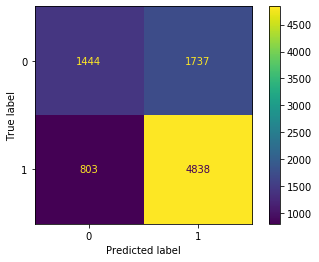

In [0]:
# Logistic Regression (baseline)
# Seed with random_state of 0.
# Increase max iterations. The default value (100) was too low.
logreg_clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

logreg_acc, logreg_f1, logreg_f2 = getModelScores(logreg_clf, name="baseline Logistic Regression")

In [0]:
%%time
# Model 2: Support Vector Machines (SVM)
# We use the SVC version from sci-kit learn.
# SVC = C-Support Vector Classification. 
# "C" is a regularization parameter > 0. Strength of regularization = 1/C

# Let's use grid search to determine best hyperparameters.
# Idea from https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py
C_range = np.logspace(-2, 4, 10)
gamma_range = np.logspace(-9, 3, 10)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv, verbose=100)
grid.fit(X_valid, y_valid)

print(f"The best hyperparameters are {grid.best_params_} with a score of {grid.best_score_:0.2f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] C=0.01, gamma=1e-09 .............................................
[CV] ................. C=0.01, gamma=1e-09, score=0.632, total=   2.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[CV] C=0.01, gamma=1e-09 .............................................
[CV] ................. C=0.01, gamma=1e-09, score=0.632, total=   2.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[CV] C=0.01, gamma=1e-09 .............................................
[CV] ................. C=0.01, gamma=1e-09, score=0.632, total=   2.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.3s remaining:    0.0s
[CV] C=0.01, gamma=1e-09 .............................................
[CV] ................. C=0.01, gamma=1e-09, score=0.632, total=   2.3s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elap

[CV] ..... C=0.01, gamma=2.154434690031878, score=0.632, total=   2.4s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  1.3min remaining:    0.0s
[CV] C=0.01, gamma=2.154434690031878 .................................
[CV] ..... C=0.01, gamma=2.154434690031878, score=0.632, total=   2.4s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:  1.4min remaining:    0.0s
[CV] C=0.01, gamma=2.154434690031878 .................................
[CV] ..... C=0.01, gamma=2.154434690031878, score=0.632, total=   2.4s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  1.4min remaining:    0.0s
[CV] C=0.01, gamma=2.154434690031878 .................................
[CV] ..... C=0.01, gamma=2.154434690031878, score=0.632, total=   2.4s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.4min remaining:    0.0s
[CV] C=0.01, gamma=46.41588833612773 .................................
[CV] ..... C=0.01, gamma=46.41588833612773, score=0.632, total=   2.2s
[Parallel(n_jobs=1)]: Done  41 out of  41

[CV]  C=0.046415888336127774, gamma=0.00021544346900318823, score=0.672, total=   2.2s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  2.6min remaining:    0.0s
[CV] C=0.046415888336127774, gamma=0.00021544346900318823 ............
[CV]  C=0.046415888336127774, gamma=0.00021544346900318823, score=0.678, total=   2.2s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  2.7min remaining:    0.0s
[CV] C=0.046415888336127774, gamma=0.004641588833612773 ..............
[CV]  C=0.046415888336127774, gamma=0.004641588833612773, score=0.671, total=   2.5s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:  2.7min remaining:    0.0s
[CV] C=0.046415888336127774, gamma=0.004641588833612773 ..............
[CV]  C=0.046415888336127774, gamma=0.004641588833612773, score=0.684, total=   2.5s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:  2.8min remaining:    0.0s
[CV] C=0.046415888336127774, gamma=0.004641588833612773 ..............
[CV]  C=0.046415888336127774, gamma=0.00464158883361

[CV]  C=0.21544346900318834, gamma=4.6415888336127725e-07, score=0.660, total=   2.1s
[CV] C=0.21544346900318834, gamma=1e-05 ..............................
[CV] .. C=0.21544346900318834, gamma=1e-05, score=0.669, total=   2.4s
[CV] C=0.21544346900318834, gamma=1e-05 ..............................
[CV] .. C=0.21544346900318834, gamma=1e-05, score=0.686, total=   2.3s
[CV] C=0.21544346900318834, gamma=1e-05 ..............................
[CV] .. C=0.21544346900318834, gamma=1e-05, score=0.678, total=   2.6s
[CV] C=0.21544346900318834, gamma=1e-05 ..............................
[CV] .. C=0.21544346900318834, gamma=1e-05, score=0.682, total=   2.3s
[CV] C=0.21544346900318834, gamma=1e-05 ..............................
[CV] .. C=0.21544346900318834, gamma=1e-05, score=0.673, total=   2.4s
[CV] C=0.21544346900318834, gamma=0.00021544346900318823 .............
[CV]  C=0.21544346900318834, gamma=0.00021544346900318823, score=0.671, total=   2.4s
[CV] C=0.21544346900318834, gamma=0.00021544346

[CV] . C=1.0, gamma=0.00021544346900318823, score=0.670, total=   2.6s
[CV] C=1.0, gamma=0.00021544346900318823 .............................
[CV] . C=1.0, gamma=0.00021544346900318823, score=0.685, total=   2.6s
[CV] C=1.0, gamma=0.00021544346900318823 .............................
[CV] . C=1.0, gamma=0.00021544346900318823, score=0.678, total=   2.6s
[CV] C=1.0, gamma=0.00021544346900318823 .............................
[CV] . C=1.0, gamma=0.00021544346900318823, score=0.669, total=   2.6s
[CV] C=1.0, gamma=0.00021544346900318823 .............................
[CV] . C=1.0, gamma=0.00021544346900318823, score=0.675, total=   2.6s
[CV] C=1.0, gamma=0.004641588833612773 ...............................
[CV] ... C=1.0, gamma=0.004641588833612773, score=0.672, total=   2.6s
[CV] C=1.0, gamma=0.004641588833612773 ...............................
[CV] ... C=1.0, gamma=0.004641588833612773, score=0.687, total=   2.6s
[CV] C=1.0, gamma=0.004641588833612773 ...............................
[CV] .

[CV]  C=4.6415888336127775, gamma=0.004641588833612773, score=0.715, total=   2.7s
[CV] C=4.6415888336127775, gamma=0.004641588833612773 ................
[CV]  C=4.6415888336127775, gamma=0.004641588833612773, score=0.698, total=   2.7s
[CV] C=4.6415888336127775, gamma=0.004641588833612773 ................
[CV]  C=4.6415888336127775, gamma=0.004641588833612773, score=0.714, total=   2.6s
[CV] C=4.6415888336127775, gamma=0.1 .................................
[CV] ..... C=4.6415888336127775, gamma=0.1, score=0.673, total=   2.4s
[CV] C=4.6415888336127775, gamma=0.1 .................................
[CV] ..... C=4.6415888336127775, gamma=0.1, score=0.669, total=   2.4s
[CV] C=4.6415888336127775, gamma=0.1 .................................
[CV] ..... C=4.6415888336127775, gamma=0.1, score=0.696, total=   2.4s
[CV] C=4.6415888336127775, gamma=0.1 .................................
[CV] ..... C=4.6415888336127775, gamma=0.1, score=0.668, total=   2.4s
[CV] C=4.6415888336127775, gamma=0.1 ....

[CV] ...... C=21.54434690031882, gamma=0.1, score=0.663, total=   3.3s
[CV] C=21.54434690031882, gamma=0.1 ..................................
[CV] ...... C=21.54434690031882, gamma=0.1, score=0.671, total=   3.3s
[CV] C=21.54434690031882, gamma=2.154434690031878 ....................
[CV]  C=21.54434690031882, gamma=2.154434690031878, score=0.637, total=   2.3s
[CV] C=21.54434690031882, gamma=2.154434690031878 ....................
[CV]  C=21.54434690031882, gamma=2.154434690031878, score=0.645, total=   2.3s
[CV] C=21.54434690031882, gamma=2.154434690031878 ....................
[CV]  C=21.54434690031882, gamma=2.154434690031878, score=0.639, total=   2.3s
[CV] C=21.54434690031882, gamma=2.154434690031878 ....................
[CV]  C=21.54434690031882, gamma=2.154434690031878, score=0.641, total=   2.3s
[CV] C=21.54434690031882, gamma=2.154434690031878 ....................
[CV]  C=21.54434690031882, gamma=2.154434690031878, score=0.638, total=   2.3s
[CV] C=21.54434690031882, gamma=46.41

[CV] .... C=100.0, gamma=46.41588833612773, score=0.636, total=   2.4s
[CV] C=100.0, gamma=46.41588833612773 ................................
[CV] .... C=100.0, gamma=46.41588833612773, score=0.633, total=   2.2s
[CV] C=100.0, gamma=46.41588833612773 ................................
[CV] .... C=100.0, gamma=46.41588833612773, score=0.636, total=   2.2s
[CV] C=100.0, gamma=46.41588833612773 ................................
[CV] .... C=100.0, gamma=46.41588833612773, score=0.632, total=   2.2s
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] ............... C=100.0, gamma=1000.0, score=0.630, total=   2.2s
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] ............... C=100.0, gamma=1000.0, score=0.633, total=   2.3s
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] ............... C=100.0, gamma=1000.0, score=0.632, total=   2.2s
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] .

[CV] ... C=464.1588833612773, gamma=1000.0, score=0.632, total=   2.3s
[CV] C=464.1588833612773, gamma=1000.0 ...............................
[CV] ... C=464.1588833612773, gamma=1000.0, score=0.633, total=   2.3s
[CV] C=464.1588833612773, gamma=1000.0 ...............................
[CV] ... C=464.1588833612773, gamma=1000.0, score=0.630, total=   2.3s
[CV] C=2154.4346900318824, gamma=1e-09 ...............................
[CV] ... C=2154.4346900318824, gamma=1e-09, score=0.632, total=   2.6s
[CV] C=2154.4346900318824, gamma=1e-09 ...............................
[CV] ... C=2154.4346900318824, gamma=1e-09, score=0.632, total=   2.6s
[CV] C=2154.4346900318824, gamma=1e-09 ...............................
[CV] ... C=2154.4346900318824, gamma=1e-09, score=0.632, total=   2.7s
[CV] C=2154.4346900318824, gamma=1e-09 ...............................
[CV] ... C=2154.4346900318824, gamma=1e-09, score=0.632, total=   2.7s
[CV] C=2154.4346900318824, gamma=1e-09 ...............................
[CV] .

[CV] .............. C=10000.0, gamma=1e-09, score=0.632, total=   2.9s
[CV] C=10000.0, gamma=1e-09 ..........................................
[CV] .............. C=10000.0, gamma=1e-09, score=0.632, total=   2.7s
[CV] C=10000.0, gamma=2.1544346900318822e-08 .........................
[CV]  C=10000.0, gamma=2.1544346900318822e-08, score=0.680, total=   4.2s
[CV] C=10000.0, gamma=2.1544346900318822e-08 .........................
[CV]  C=10000.0, gamma=2.1544346900318822e-08, score=0.686, total=   4.2s
[CV] C=10000.0, gamma=2.1544346900318822e-08 .........................
[CV]  C=10000.0, gamma=2.1544346900318822e-08, score=0.687, total=   4.4s
[CV] C=10000.0, gamma=2.1544346900318822e-08 .........................
[CV]  C=10000.0, gamma=2.1544346900318822e-08, score=0.675, total=   4.5s
[CV] C=10000.0, gamma=2.1544346900318822e-08 .........................
[CV]  C=10000.0, gamma=2.1544346900318822e-08, score=0.683, total=   4.8s
[CV] C=10000.0, gamma=4.6415888336127725e-07 .................

Output from above Grid Search:

The best hyperparameters are {'C': 10000.0, 'gamma': 1e-05} with a score of 0.73

The accuracy of the SVM model is 0.7246343951932888
The F1 Score of the SVM model is 0.7887274941289033
The F2 Score of the SVM model is 0.8035302874561373
CPU times: user 2min 58s, sys: 106 ms, total: 2min 58s
Wall time: 2min 57s


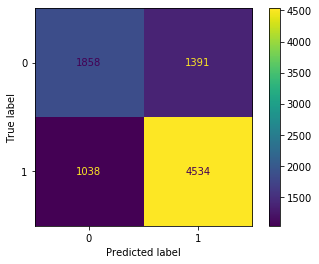

In [0]:
%%time
svm_clf = SVC(C=10000.0, gamma=1e-05).fit(X_train, y_train)

# Let's use the validation parameters.
# We will use a grid search to test hyperparameters after 
svm_acc, svm_f1, svm_f2 = getModelScores(svm_clf, name="SVM", valid=True)

In [0]:
# Model 3: Neural Networks
!pygmentize src/model.py

"""Code originally from Jupyter Notebook.
Moved to separate Python file due to kernel
repeatedly dying.

"""
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from collections import defaultdict
from datetime import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedShuffleSplit,
    train_test_split,
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp


log_dir = "logs/hparam_tuning_small_2lyrs/"


# Read in saved data.
combined = pd.read_csv(os.path.join("formatted_data", "combined.csv"))

# Seed the random generator, so we get the same results each time
random_seed_1 = 3141592
random_seed_2 = 8675309

# Specify which column contains 

    model = keras.Sequential()
    # First hidden layer.
    model.add(
        keras.layers.Dense(
            hparams[HP_NUM_UNITS_1], activation="relu", input_shape=[X_train.shape[1]]
        )
    )
    model.add(keras.layers.Dropout(hparams[HP_DROPOUT_1]))
    # Possibly add second hidden layer.
    if hparams[HP_NUM_LAYERS] == 2:
        model.add(keras.layers.Dense(hparams[HP_NUM_UNITS_2], activation="relu"))
        model.add(keras.layers.Dropout(hparams[HP_DROPOUT_2]))
    # Output Layer
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    # Display model summary
    model.summary()

    # Initialize optimizer with learning rate.
    if hparams[HP_OPTIMIZER] == "adam":
        optim = keras.optimizers.Adam(learning_rate=hparams[HP_OPTIM_LR])
    elif hparams[HP_OPTIMIZER] == "sgd":
        optim = keras.optimizers.SGD(learning_rate=hparams[HP_OPTIM_LR])

    # Compile the model.
    model.compile(
        optimizer=optim,
        loss="binary_crossentropy",
        

In [0]:
# Load TensorBoard notebook extension
%load_ext tensorboard

# Start Tensorboard and click HParams at the top to view the dashboard.
%tensorboard --logdir logs/hparam_tuning_final/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6009 (pid 24953), started 1 day, 17:24:15 ago. (Use '!kill 24953' to kill it.)

In [0]:
final_params = {
    "NUM_UNITS_1": 128,
    "DROPOUT_1": 0.3,
    "NUM_UNITS_2": 32,
    "DROPOUT_2": 0.2,
    "LR": 1e-4
}

def run_model(params):
    """Perform hyperparameter tuning on the validation set."""
    model = keras.Sequential()
    # First hidden layer.
    model.add(
        keras.layers.Dense(
            params["NUM_UNITS_1"], activation="relu", input_shape=[X_train.shape[1]]
        )
    )
    model.add(keras.layers.Dropout(params["DROPOUT_1"]))
    model.add(keras.layers.Dense(params["NUM_UNITS_2"], activation="relu"))
    model.add(keras.layers.Dropout(params["DROPOUT_2"]))
    
    # Output Layer
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    # Display model summary
    model.summary()

    # Initialize optimizer with learning rate.
    optim = keras.optimizers.Adam(learning_rate=params["LR"])
    
    # Compile the model.
    model.compile(
        optimizer=optim,
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.FalseNegatives(),
            tf.keras.metrics.FalsePositives(),
            tf.keras.metrics.TrueNegatives(),
            tf.keras.metrics.TruePositives(),
        ],
    )

    # Callbacks
    # Early Stopping
    #   -monitor validation loss.
    #   -when validation loss stops decreasing, stop.
    #   -patience is number of epochs with no improvement.
    cb_es = keras.callbacks.EarlyStopping(
        monitor="val_loss", mode="min", patience=20, verbose=2
    )
    # Model Checkpoint
    #   -call our model "best_model.h5".
    #   -monitor validation loss.
    #   -when validation loss stops decreasing, stop.
    #   -save the best overall model.
    cb_ckpt = keras.callbacks.ModelCheckpoint(
        "best_model_final.h5",
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        verbose=2,
    )

    # Fit
    model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),
        callbacks=[cb_es, cb_ckpt],
        epochs=X_train.shape[0],  # Train up to number of data rows, or stop early.
        verbose=2,
    )
    
    # Evaluate the test set.
    _, test_acc, test_fn, test_fp, test_tn, test_tp = model.evaluate(
        X_test, y_test, verbose=2
    )

    return test_acc, test_fn, test_fp, test_tn, test_tp


acc, fn, fp, tn, tp = run_model(final_params)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 128)               3072      
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 33        
Total params: 7,233
Trainable params: 7,233
Non-trainable params: 0
_________________________________________________________________
Train on 26463 samples, validate on 8821 samples
Epoch 1/26463

Epoch 00001: val_loss improved from inf to 5.64762, s

Epoch 17/26463

Epoch 00017: val_loss did not improve from 0.64278
26463/26463 - 2s - loss: 0.6483 - accuracy: 0.6305 - false_negatives_12: 5.0000 - false_positives_12: 9773.0000 - true_negatives_12: 5.0000 - true_positives_12: 16680.0000 - val_loss: 0.6440 - val_accuracy: 0.6317 - val_false_negatives_12: 0.0000e+00 - val_false_positives_12: 3249.0000 - val_true_negatives_12: 0.0000e+00 - val_true_positives_12: 5572.0000
Epoch 18/26463

Epoch 00018: val_loss did not improve from 0.64278
26463/26463 - 2s - loss: 0.6500 - accuracy: 0.6302 - false_negatives_12: 10.0000 - false_positives_12: 9776.0000 - true_negatives_12: 2.0000 - true_positives_12: 16675.0000 - val_loss: 0.6448 - val_accuracy: 0.6317 - val_false_negatives_12: 0.0000e+00 - val_false_positives_12: 3249.0000 - val_true_negatives_12: 0.0000e+00 - val_true_positives_12: 5572.0000
Epoch 19/26463

Epoch 00019: val_loss improved from 0.64278 to 0.64243, saving model to best_model_final.h5
26463/26463 - 2s - loss: 0.6489 - accurac

Epoch 36/26463

Epoch 00036: val_loss did not improve from 0.64003
26463/26463 - 2s - loss: 0.6456 - accuracy: 0.6300 - false_negatives_12: 67.0000 - false_positives_12: 9725.0000 - true_negatives_12: 53.0000 - true_positives_12: 16618.0000 - val_loss: 0.6434 - val_accuracy: 0.6317 - val_false_negatives_12: 0.0000e+00 - val_false_positives_12: 3249.0000 - val_true_negatives_12: 0.0000e+00 - val_true_positives_12: 5572.0000
Epoch 37/26463

Epoch 00037: val_loss improved from 0.64003 to 0.63995, saving model to best_model_final.h5
26463/26463 - 2s - loss: 0.6439 - accuracy: 0.6305 - false_negatives_12: 65.0000 - false_positives_12: 9714.0000 - true_negatives_12: 64.0000 - true_positives_12: 16620.0000 - val_loss: 0.6399 - val_accuracy: 0.6317 - val_false_negatives_12: 0.0000e+00 - val_false_positives_12: 3249.0000 - val_true_negatives_12: 0.0000e+00 - val_true_positives_12: 5572.0000
Epoch 38/26463

Epoch 00038: val_loss did not improve from 0.63995
26463/26463 - 2s - loss: 0.6461 - accu

Epoch 54/26463

Epoch 00054: val_loss improved from 0.63353 to 0.63156, saving model to best_model_final.h5
26463/26463 - 2s - loss: 0.6394 - accuracy: 0.6310 - false_negatives_12: 238.0000 - false_positives_12: 9526.0000 - true_negatives_12: 252.0000 - true_positives_12: 16447.0000 - val_loss: 0.6316 - val_accuracy: 0.6317 - val_false_negatives_12: 0.0000e+00 - val_false_positives_12: 3249.0000 - val_true_negatives_12: 0.0000e+00 - val_true_positives_12: 5572.0000
Epoch 55/26463

Epoch 00055: val_loss improved from 0.63156 to 0.63077, saving model to best_model_final.h5
26463/26463 - 2s - loss: 0.6388 - accuracy: 0.6318 - false_negatives_12: 316.0000 - false_positives_12: 9428.0000 - true_negatives_12: 350.0000 - true_positives_12: 16369.0000 - val_loss: 0.6308 - val_accuracy: 0.6320 - val_false_negatives_12: 0.0000e+00 - val_false_positives_12: 3246.0000 - val_true_negatives_12: 3.0000 - val_true_positives_12: 5572.0000
Epoch 56/26463

Epoch 00056: val_loss improved from 0.63077 to 0

Epoch 72/26463

Epoch 00072: val_loss did not improve from 0.60089
26463/26463 - 2s - loss: 0.6112 - accuracy: 0.6812 - false_negatives_12: 2326.0000 - false_positives_12: 6111.0000 - true_negatives_12: 3667.0000 - true_positives_12: 14359.0000 - val_loss: 0.6022 - val_accuracy: 0.6871 - val_false_negatives_12: 1008.0000 - val_false_positives_12: 1752.0000 - val_true_negatives_12: 1497.0000 - val_true_positives_12: 4564.0000
Epoch 73/26463

Epoch 00073: val_loss improved from 0.60089 to 0.59862, saving model to best_model_final.h5
26463/26463 - 2s - loss: 0.6123 - accuracy: 0.6795 - false_negatives_12: 2480.0000 - false_positives_12: 6002.0000 - true_negatives_12: 3776.0000 - true_positives_12: 14205.0000 - val_loss: 0.5986 - val_accuracy: 0.6953 - val_false_negatives_12: 765.0000 - val_false_positives_12: 1923.0000 - val_true_negatives_12: 1326.0000 - val_true_positives_12: 4807.0000
Epoch 74/26463

Epoch 00074: val_loss did not improve from 0.59862
26463/26463 - 2s - loss: 0.6114 - a

Epoch 91/26463

Epoch 00091: val_loss did not improve from 0.58258
26463/26463 - 2s - loss: 0.5974 - accuracy: 0.6882 - false_negatives_12: 2330.0000 - false_positives_12: 5920.0000 - true_negatives_12: 3858.0000 - true_positives_12: 14355.0000 - val_loss: 0.5832 - val_accuracy: 0.6964 - val_false_negatives_12: 660.0000 - val_false_positives_12: 2018.0000 - val_true_negatives_12: 1231.0000 - val_true_positives_12: 4912.0000
Epoch 92/26463

Epoch 00092: val_loss did not improve from 0.58258
26463/26463 - 2s - loss: 0.5967 - accuracy: 0.6853 - false_negatives_12: 2430.0000 - false_positives_12: 5897.0000 - true_negatives_12: 3881.0000 - true_positives_12: 14255.0000 - val_loss: 0.5856 - val_accuracy: 0.6888 - val_false_negatives_12: 992.0000 - val_false_positives_12: 1753.0000 - val_true_negatives_12: 1496.0000 - val_true_positives_12: 4580.0000
Epoch 93/26463

Epoch 00093: val_loss did not improve from 0.58258
26463/26463 - 2s - loss: 0.5951 - accuracy: 0.6869 - false_negatives_12: 2377

Epoch 110/26463

Epoch 00110: val_loss improved from 0.56946 to 0.56939, saving model to best_model_final.h5
26463/26463 - 2s - loss: 0.5851 - accuracy: 0.6899 - false_negatives_12: 2224.0000 - false_positives_12: 5981.0000 - true_negatives_12: 3797.0000 - true_positives_12: 14461.0000 - val_loss: 0.5694 - val_accuracy: 0.6982 - val_false_negatives_12: 605.0000 - val_false_positives_12: 2057.0000 - val_true_negatives_12: 1192.0000 - val_true_positives_12: 4967.0000
Epoch 111/26463

Epoch 00111: val_loss did not improve from 0.56939
26463/26463 - 2s - loss: 0.5843 - accuracy: 0.6910 - false_negatives_12: 2256.0000 - false_positives_12: 5921.0000 - true_negatives_12: 3857.0000 - true_positives_12: 14429.0000 - val_loss: 0.5706 - val_accuracy: 0.6921 - val_false_negatives_12: 890.0000 - val_false_positives_12: 1826.0000 - val_true_negatives_12: 1423.0000 - val_true_positives_12: 4682.0000
Epoch 112/26463

Epoch 00112: val_loss did not improve from 0.56939
26463/26463 - 2s - loss: 0.5831 -

Epoch 129/26463

Epoch 00129: val_loss did not improve from 0.55766
26463/26463 - 2s - loss: 0.5755 - accuracy: 0.6988 - false_negatives_12: 2387.0000 - false_positives_12: 5584.0000 - true_negatives_12: 4194.0000 - true_positives_12: 14298.0000 - val_loss: 0.5604 - val_accuracy: 0.7075 - val_false_negatives_12: 907.0000 - val_false_positives_12: 1673.0000 - val_true_negatives_12: 1576.0000 - val_true_positives_12: 4665.0000
Epoch 130/26463

Epoch 00130: val_loss did not improve from 0.55766
26463/26463 - 2s - loss: 0.5769 - accuracy: 0.6997 - false_negatives_12: 2487.0000 - false_positives_12: 5460.0000 - true_negatives_12: 4318.0000 - true_positives_12: 14198.0000 - val_loss: 0.5615 - val_accuracy: 0.7049 - val_false_negatives_12: 717.0000 - val_false_positives_12: 1886.0000 - val_true_negatives_12: 1363.0000 - val_true_positives_12: 4855.0000
Epoch 131/26463

Epoch 00131: val_loss improved from 0.55766 to 0.55551, saving model to best_model_final.h5
26463/26463 - 2s - loss: 0.5740 -

Epoch 148/26463

Epoch 00148: val_loss did not improve from 0.55252
26463/26463 - 2s - loss: 0.5709 - accuracy: 0.6999 - false_negatives_12: 2468.0000 - false_positives_12: 5474.0000 - true_negatives_12: 4304.0000 - true_positives_12: 14217.0000 - val_loss: 0.5543 - val_accuracy: 0.7148 - val_false_negatives_12: 822.0000 - val_false_positives_12: 1694.0000 - val_true_negatives_12: 1555.0000 - val_true_positives_12: 4750.0000
Epoch 149/26463

Epoch 00149: val_loss improved from 0.55252 to 0.55164, saving model to best_model_final.h5
26463/26463 - 2s - loss: 0.5738 - accuracy: 0.7016 - false_negatives_12: 2492.0000 - false_positives_12: 5404.0000 - true_negatives_12: 4374.0000 - true_positives_12: 14193.0000 - val_loss: 0.5516 - val_accuracy: 0.7182 - val_false_negatives_12: 780.0000 - val_false_positives_12: 1706.0000 - val_true_negatives_12: 1543.0000 - val_true_positives_12: 4792.0000
Epoch 150/26463

Epoch 00150: val_loss did not improve from 0.55164
26463/26463 - 2s - loss: 0.5724 -

Epoch 167/26463

Epoch 00167: val_loss did not improve from 0.54811
26463/26463 - 2s - loss: 0.5694 - accuracy: 0.7045 - false_negatives_12: 2457.0000 - false_positives_12: 5362.0000 - true_negatives_12: 4416.0000 - true_positives_12: 14228.0000 - val_loss: 0.5588 - val_accuracy: 0.7109 - val_false_negatives_12: 1053.0000 - val_false_positives_12: 1497.0000 - val_true_negatives_12: 1752.0000 - val_true_positives_12: 4519.0000
Epoch 168/26463

Epoch 00168: val_loss did not improve from 0.54811
26463/26463 - 2s - loss: 0.5683 - accuracy: 0.7062 - false_negatives_12: 2576.0000 - false_positives_12: 5199.0000 - true_negatives_12: 4579.0000 - true_positives_12: 14109.0000 - val_loss: 0.5521 - val_accuracy: 0.7216 - val_false_negatives_12: 800.0000 - val_false_positives_12: 1656.0000 - val_true_negatives_12: 1593.0000 - val_true_positives_12: 4772.0000
Epoch 169/26463

Epoch 00169: val_loss did not improve from 0.54811
26463/26463 - 2s - loss: 0.5688 - accuracy: 0.7054 - false_negatives_12: 

Epoch 186/26463

Epoch 00186: val_loss did not improve from 0.54782
26463/26463 - 2s - loss: 0.5663 - accuracy: 0.7012 - false_negatives_12: 2188.0000 - false_positives_12: 5718.0000 - true_negatives_12: 4060.0000 - true_positives_12: 14497.0000 - val_loss: 0.5546 - val_accuracy: 0.7110 - val_false_negatives_12: 634.0000 - val_false_positives_12: 1915.0000 - val_true_negatives_12: 1334.0000 - val_true_positives_12: 4938.0000
Epoch 187/26463

Epoch 00187: val_loss did not improve from 0.54782
26463/26463 - 2s - loss: 0.5666 - accuracy: 0.7021 - false_negatives_12: 2206.0000 - false_positives_12: 5677.0000 - true_negatives_12: 4101.0000 - true_positives_12: 14479.0000 - val_loss: 0.5554 - val_accuracy: 0.7106 - val_false_negatives_12: 892.0000 - val_false_positives_12: 1661.0000 - val_true_negatives_12: 1588.0000 - val_true_positives_12: 4680.0000
Epoch 188/26463

Epoch 00188: val_loss did not improve from 0.54782
26463/26463 - 2s - loss: 0.5657 - accuracy: 0.7047 - false_negatives_12: 2

Epoch 205/26463

Epoch 00205: val_loss did not improve from 0.54679
26463/26463 - 2s - loss: 0.5638 - accuracy: 0.7026 - false_negatives_12: 2290.0000 - false_positives_12: 5580.0000 - true_negatives_12: 4198.0000 - true_positives_12: 14395.0000 - val_loss: 0.5532 - val_accuracy: 0.7063 - val_false_negatives_12: 523.0000 - val_false_positives_12: 2068.0000 - val_true_negatives_12: 1181.0000 - val_true_positives_12: 5049.0000
Epoch 206/26463

Epoch 00206: val_loss did not improve from 0.54679
26463/26463 - 2s - loss: 0.5659 - accuracy: 0.7031 - false_negatives_12: 2251.0000 - false_positives_12: 5606.0000 - true_negatives_12: 4172.0000 - true_positives_12: 14434.0000 - val_loss: 0.5513 - val_accuracy: 0.7116 - val_false_negatives_12: 780.0000 - val_false_positives_12: 1764.0000 - val_true_negatives_12: 1485.0000 - val_true_positives_12: 4792.0000
Epoch 207/26463

Epoch 00207: val_loss did not improve from 0.54679
26463/26463 - 2s - loss: 0.5632 - accuracy: 0.7029 - false_negatives_12: 2

The accuracy of the Neural Network model is 0.7116299867630005
The F1 Score of the Neural Network model is 0.7972585597855748
The F2 Score of the Neural Network model is 0.8486308868054929


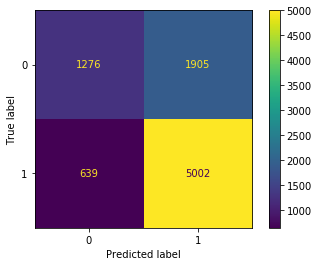

In [0]:
nn_acc, nn_f1, nn_f2 = getModelScores(np.array([[tn, fp], [fn, tp]]), name="Neural Network")

In [0]:
def loadModelAndPredict(data, name="best_model_final.h5"):
    """Load the saved model and predict the result of the data.
    
    Args:
        -data (Numpy array) = single row of new data to predict result for.
        -name = name of the model to load.
    
    Returns:
        -prediction
    """
    model = tf.keras.models.load_model(name)
    
    return model.predict(data)


# Test to confirm it works.  We will use the first test datapoint.
prediction = loadModelAndPredict(X_test.head(1).to_numpy())
actual = y_test[0]

print(f"The predicted value is {float(prediction):.2f} and the actual value is {actual}.")
print("Therefore, we were able to successfully load the model and predict using it.")

The predicted value is 0.70 and the actual value is 1.
Therefore, we were able to successfully load the model and predict using it.


## Final Outcome

- Since I was unable to run the Tensorflow models in the Jupyter notebook, due to the kernel repeatedly crashing, I ran several iterations of hyperparameter tuning with results listed below.  Details of the hyperparameters tested in each iteration will be in the final report.
- The final Neural Network model is the best model. It results in the fewest False Negatives, and has the highest F2 Score. It uses the parameters found to be the best in the 4th iteration of hyperparameter tuning against the validation set.

<div align="center"><b>Final scores using the Test Set</b></div>

| Model | Accuracy | F1 Score | F2 Score | TP | FP | TN | FN |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| Logistic Regression __\[test set\]__ | 0.71208 | 0.79208 | 0.83016 | 4838 | 1737 | 1444 | 803 |
| Support Vector Machines __\[test set\]__ | 0.72463 | 0.78873 | 0.80353 | 4534 | 1391 | 1858 | 1038 |
| Neural Network (Final) __\[test set\]__ | 0.71163 | 0.79726 | 0.84863 | 5002 | 1905 | 1276 | 639 |


<br /><br />


<div align="center"><b>Hyperparameter Tuning on Validation Set</b></div>

| Model | Accuracy | F1 Score | F2 Score | TP | FP | TN | FN |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| _Neural Network (1st iteration)_ __\[validation set\]__ | _0.72222_ | _0.79634_ | _0.82741_ | _4792_ | _1602_ | _1579_ | _849_ |
| _Neural Network (2nd iteration)_ __\[validation set\]__ | _0.7131_ | _0.79682_ | _0.84462_ | _4963_ | _1853_ | _1328_ | _678_ |
| _Neural Network (3rd iteration)_ __\[validation set\]__ | _0.71911_ | _0.805_ | _0.86312_ | _5115_ | _1952_ | _1229_ | _526_ |
| _Neural Network (4th iteration)_ __\[validation set\]__ | _0.70676_ | _0.79966_ | _0.86523_ | _5163_ | _2109_ | _1072_ | _478_ |

# Conclusion

For this project I have analyzed, cleaned, performed feature engineering, and created 3 models using the Starbucks data. I have created a Neural Network model that successfully performs propensity modeling with an F₂ Score of 0.84863 on the Test Set and the lowest False Negative score out of all my models. As mentioned previously, Starbucks was only able to achieve a 63.252% success rate during their trial. My model definitely improves upon the trial results, and so it is a success!

## Future Improvements

If I were to extend this project further, I would attempt the following:

- I would dig into the examples that were labeled as False Negatives to determine why the model incorrectly labeled them. I could then possibly apply additional feature engineering or tweak hyperparameters to reduce these.
- I would ensemble several models together to see if they improve the results.
- I would try a tree-based model like Random Forest.
- I am curious how the models would handle a new offer (other than the 10 existing offers). Would they handle this new offer with similar metric results, or would the models require additional training?
- I am also curious if certain demographics respond more to certain offer types. This information could be used to engineer new offers targeting the specific demographic.